In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 30.0, frames[0].shape[0] / 30.0), dpi = 72)
    patch = plt.imshow(frames[0], cmap='gray')
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=30)
    display(display_animation(anim, default_mode='loop'))

## Contents
* Reinforcement learning
* Q-learning 
* Gå gjennom Pseudo-algortimen fra paper
* Exploration-exploitation trade-off
* Model
* Replay memory
* Target network
* OpenAI Gym
* Putting everything together: DQN
* Training
* Using trained network / Continue learning

## OpenAi Gym

In this tutorial we will be using the OpenAi Gym library. OpenAi is a company that is doing research on reinforcement learning and provides us a easy to use library called Gym that can simulate reinforcment environments which we can interact with.

Gym can be installed using the pip command:

pip install gym

#### Example code for how to simulate the environment

The code below shows example of using the Gym library and is the code you need to know about Gym for implementing reinforcement learning. The code simulates the CartPole environment and performs random action on each frame. This means that it won't learn anything.


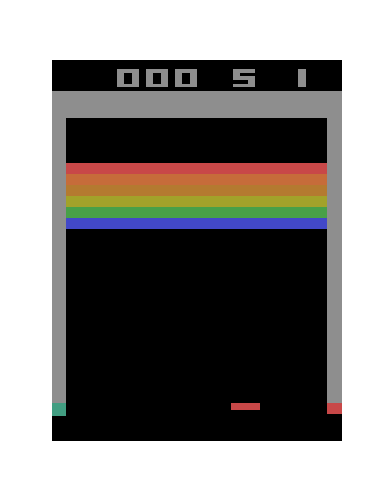
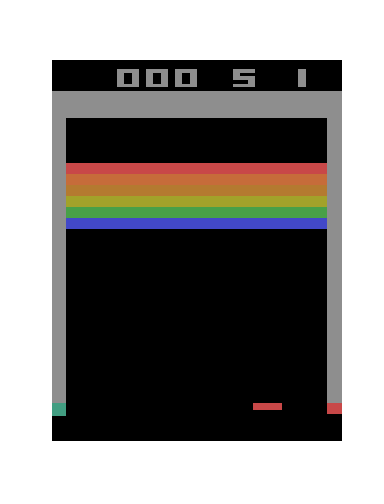
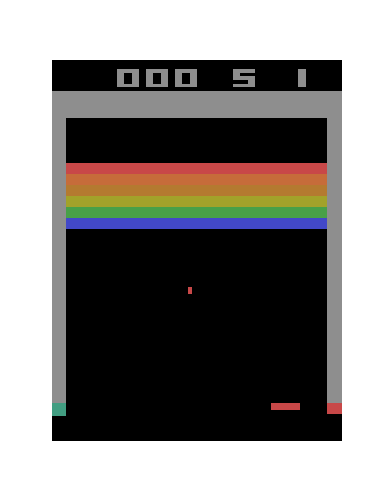
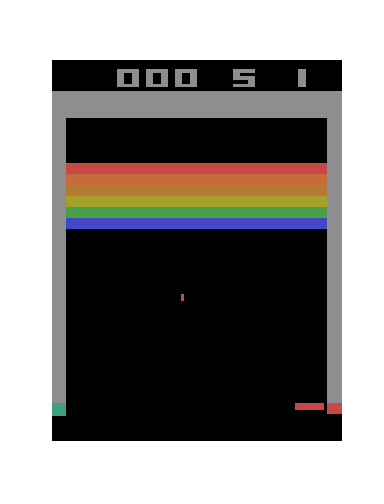
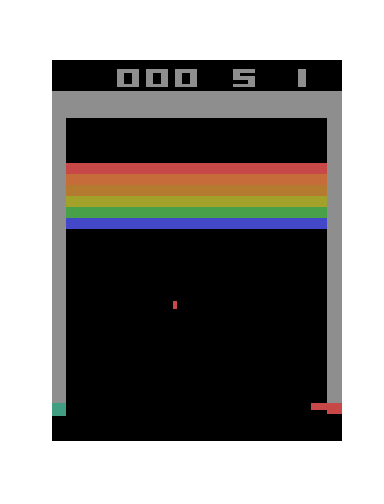
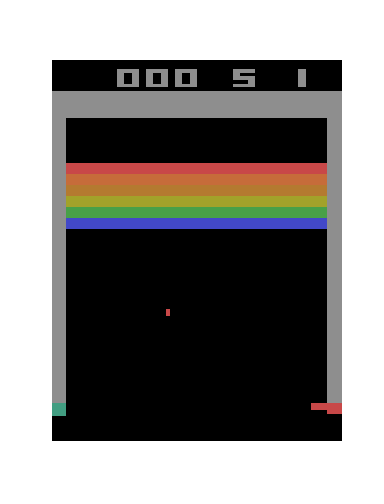
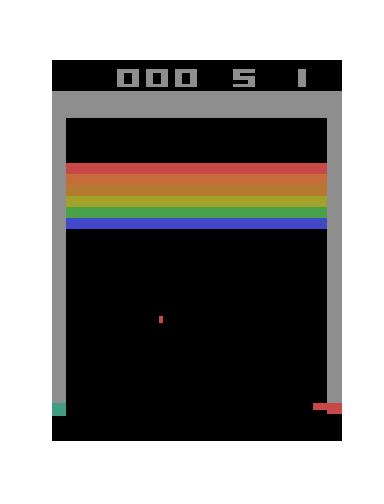
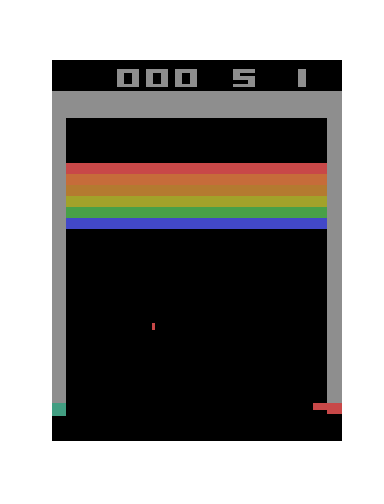
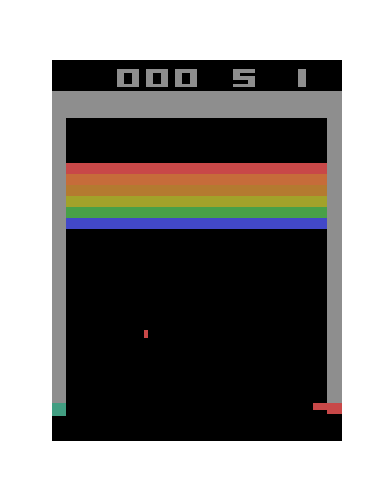
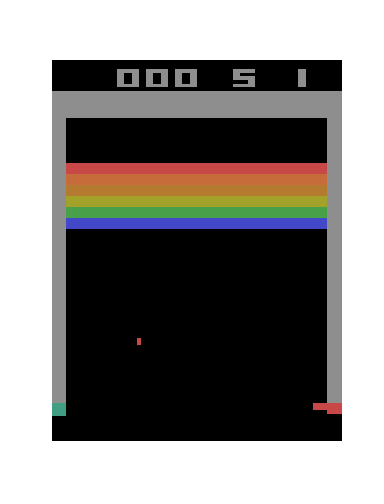
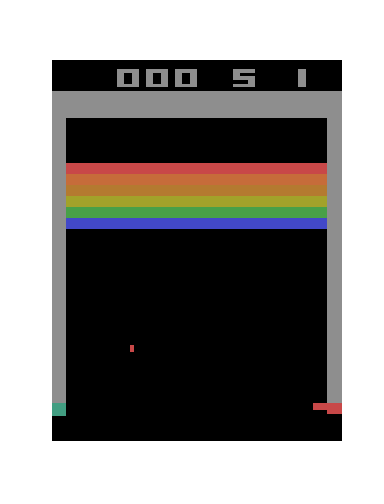
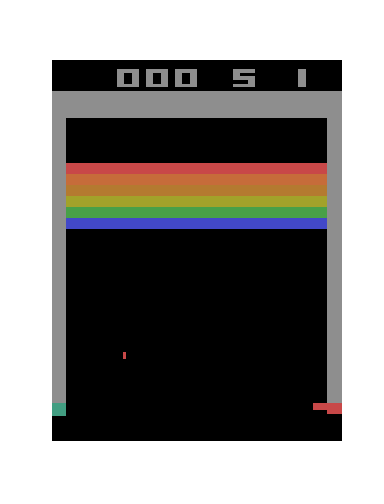
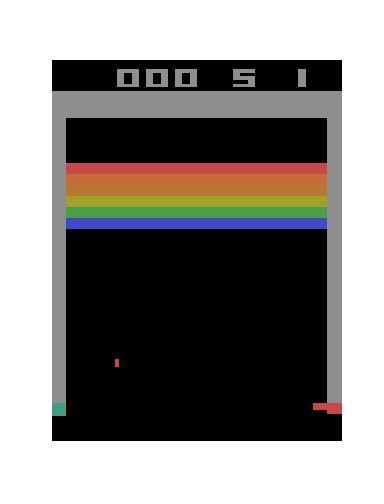
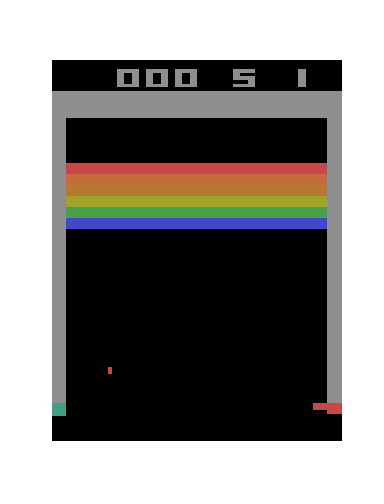
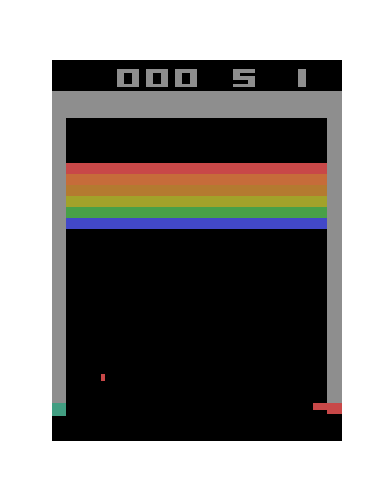
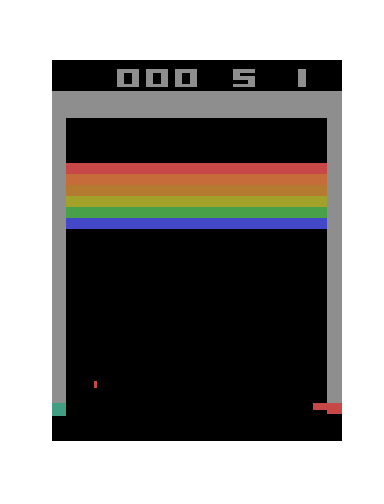
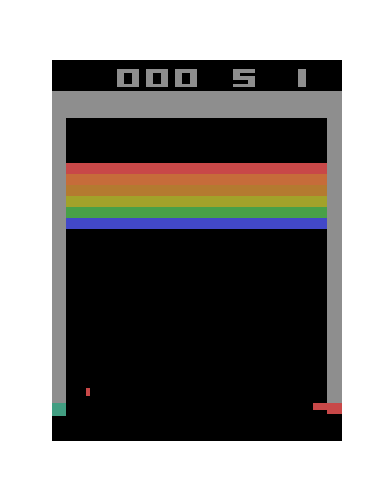
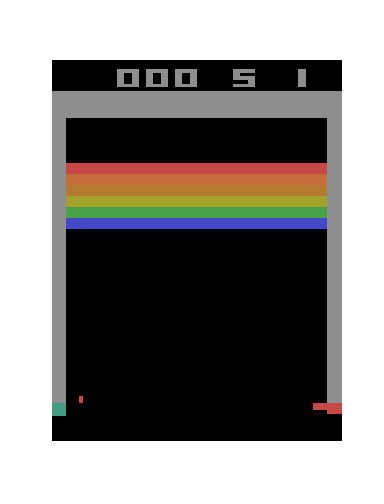
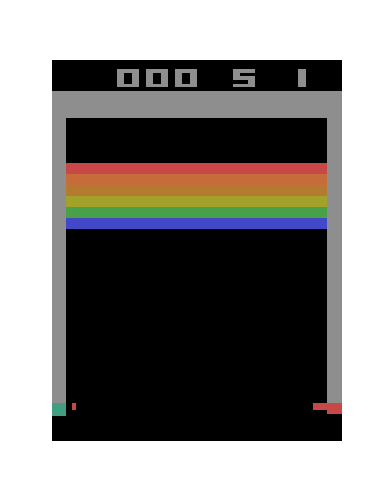
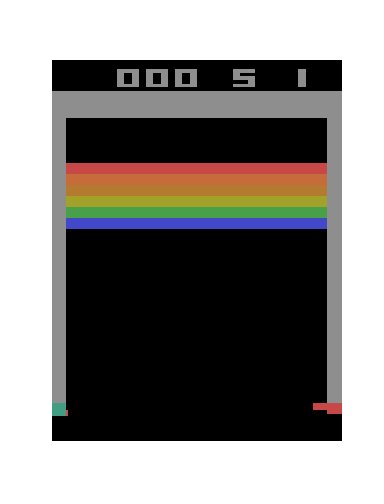
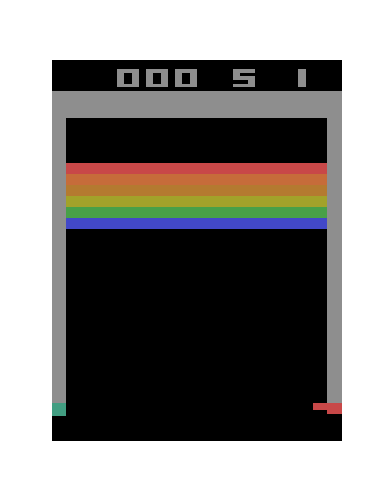
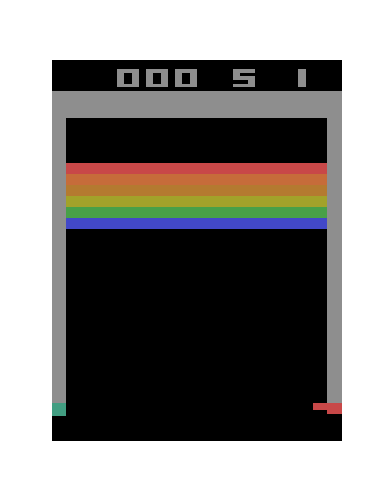
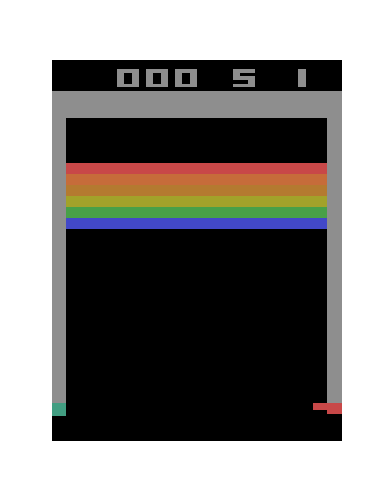
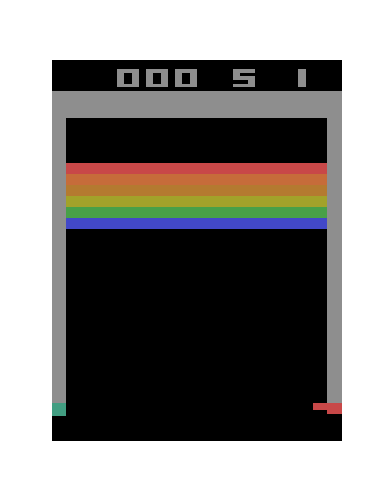
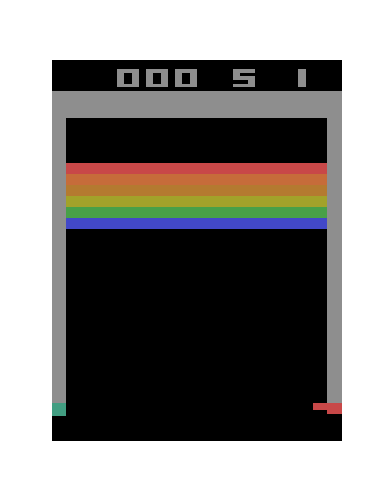
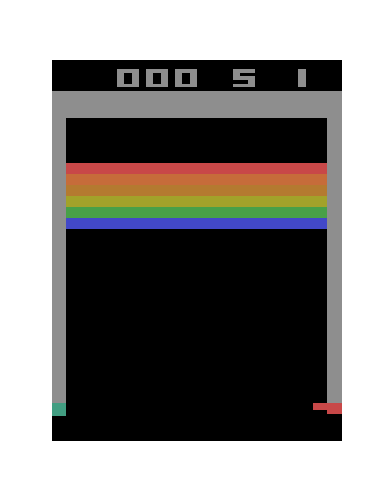
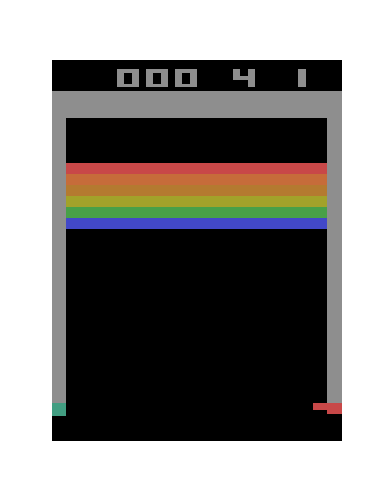
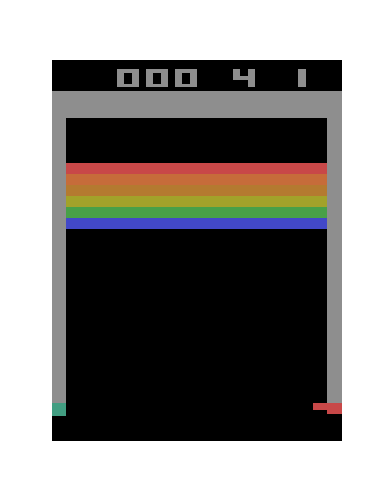
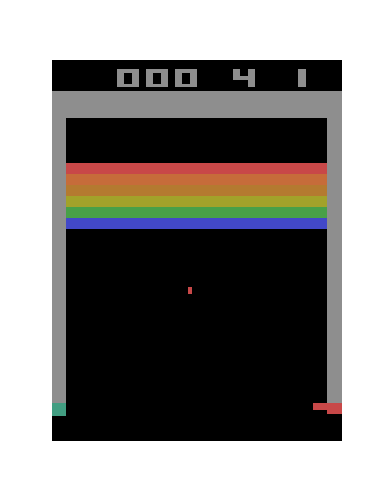
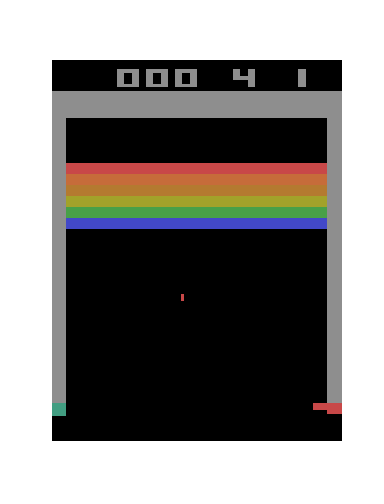
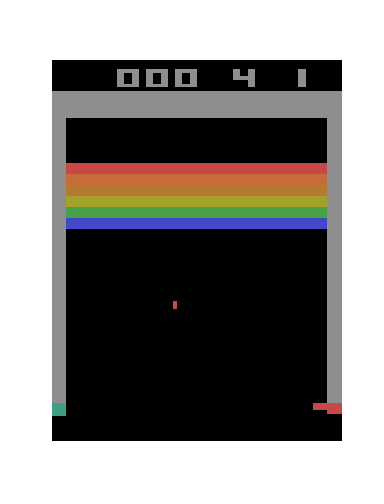
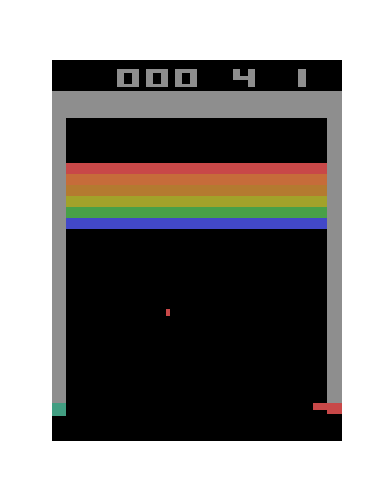
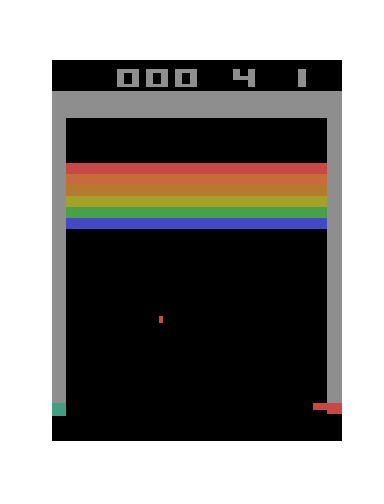
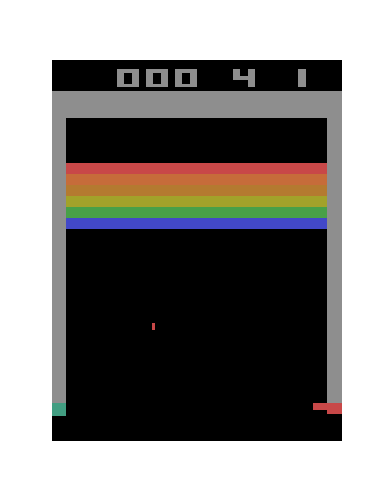
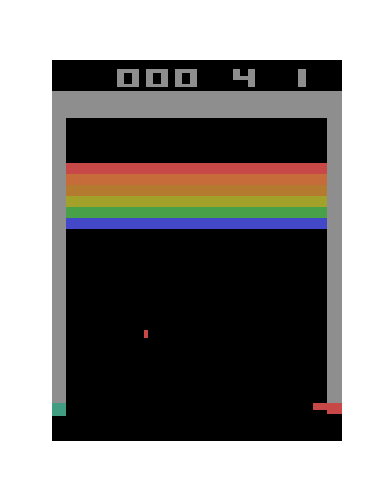
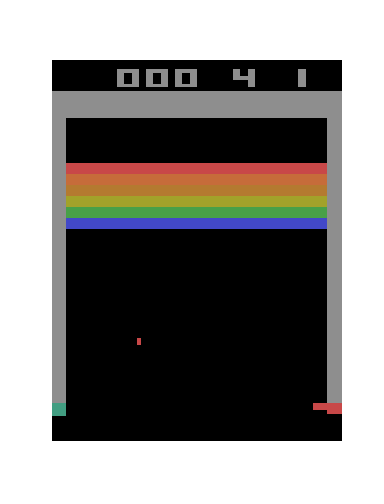
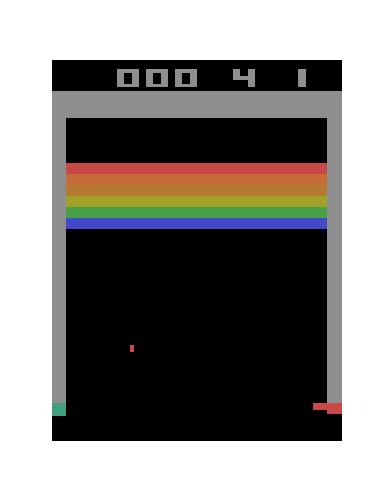
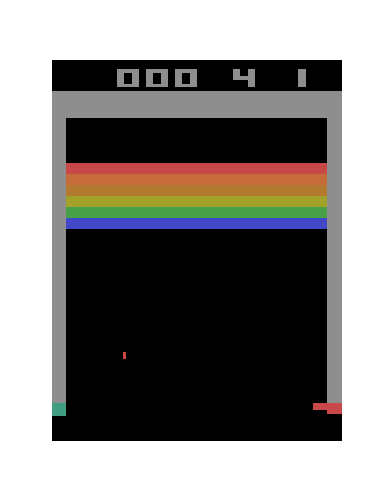
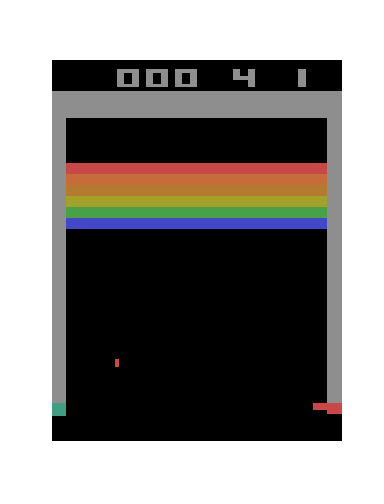
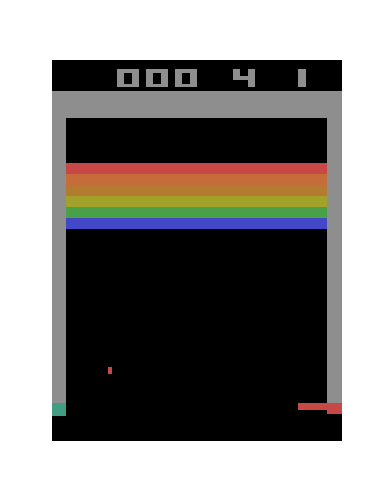
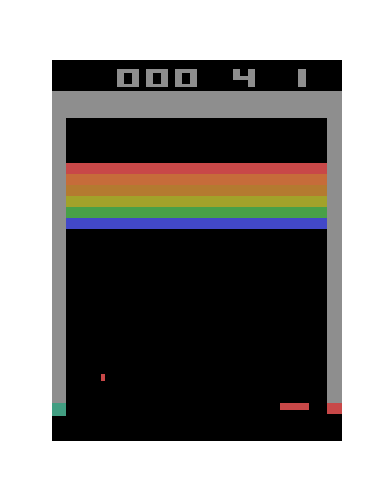
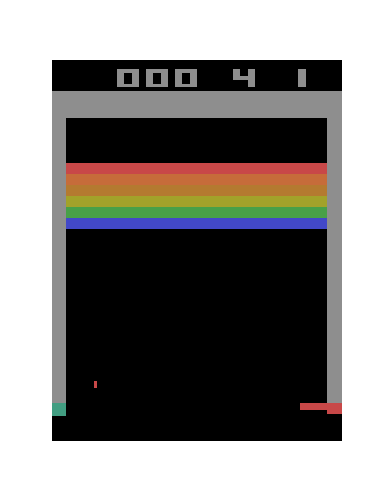
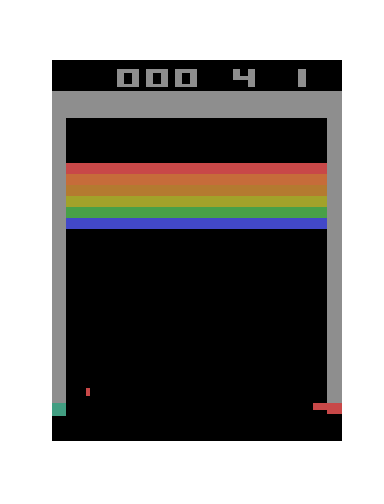
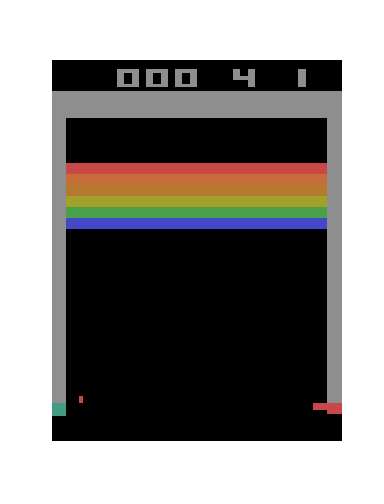
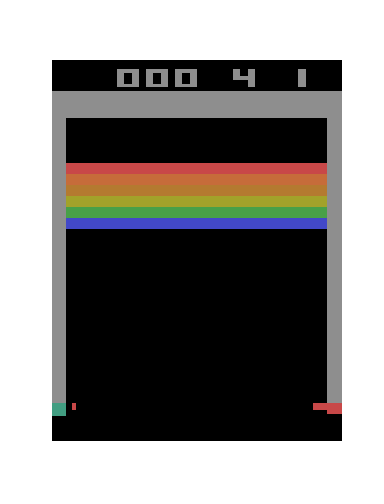
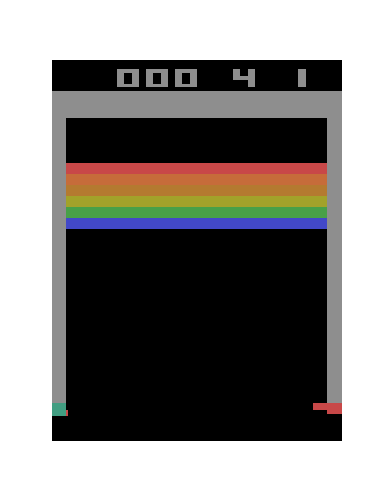
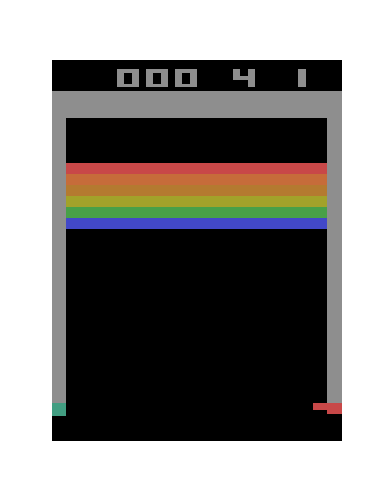
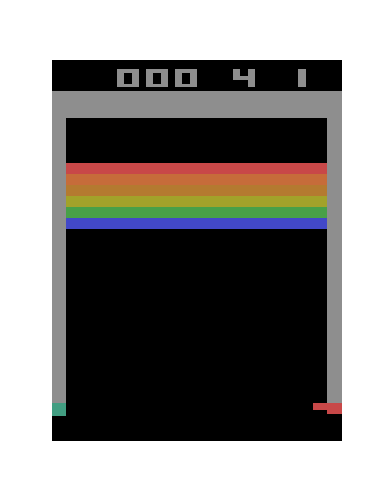
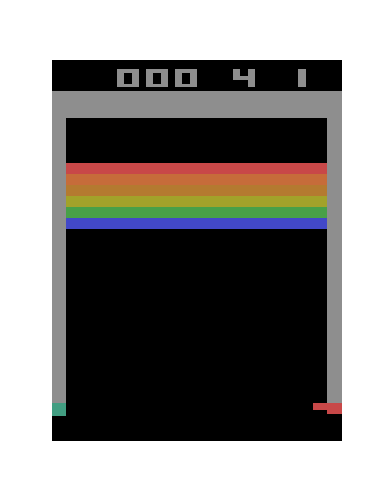
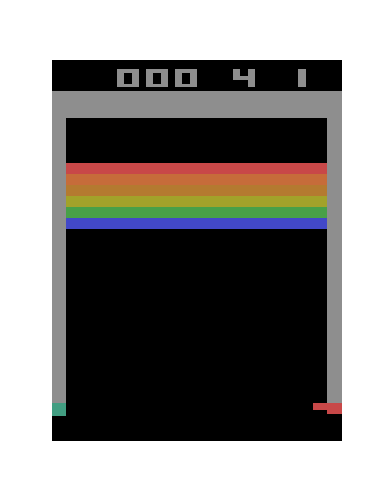
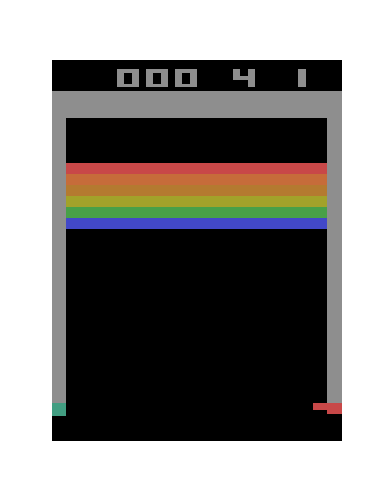
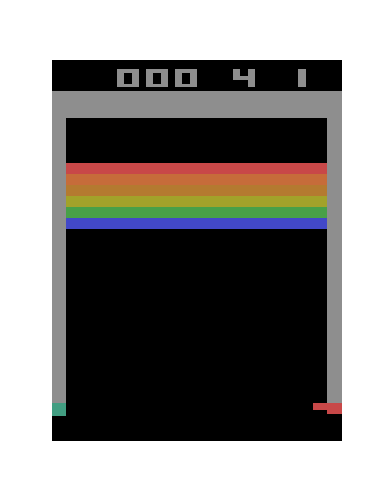
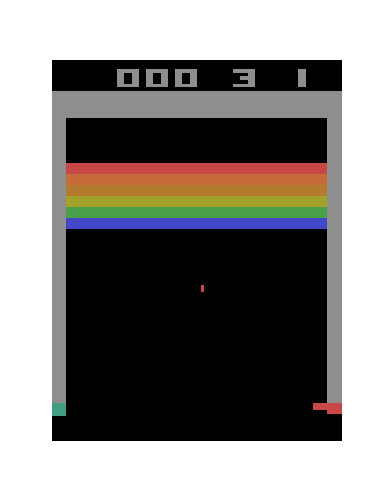
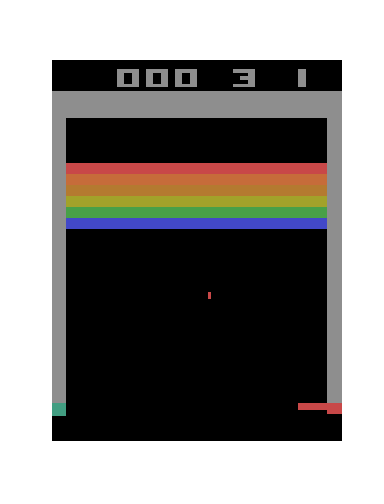
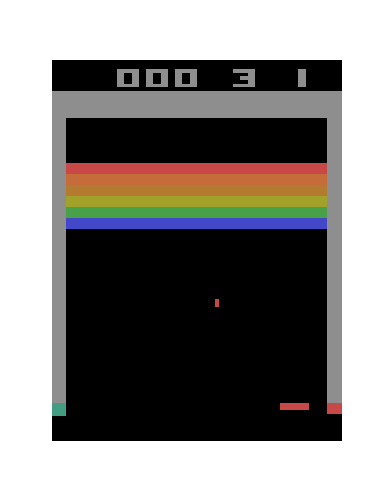
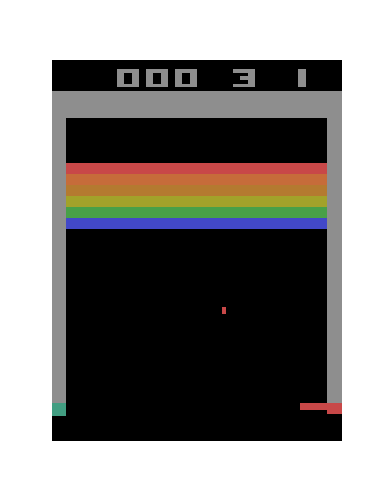
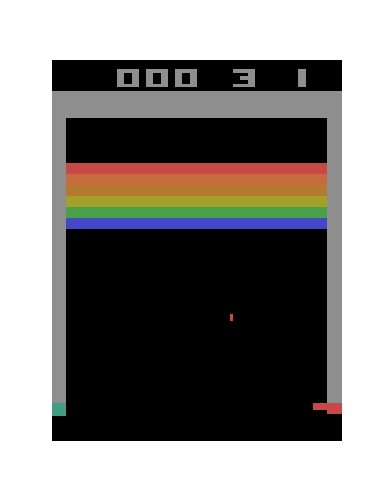
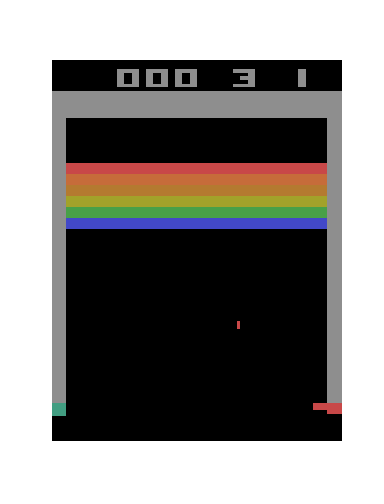
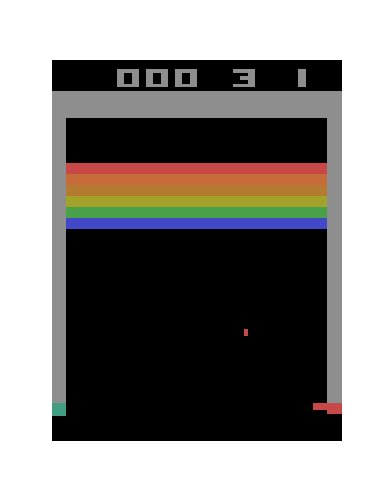
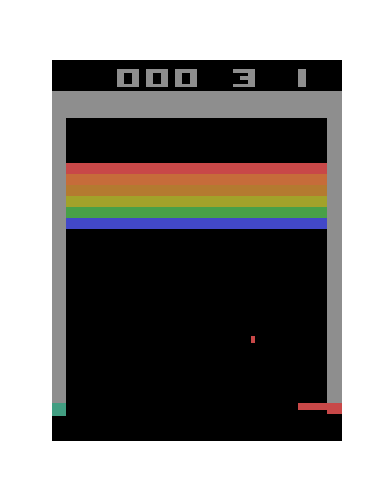
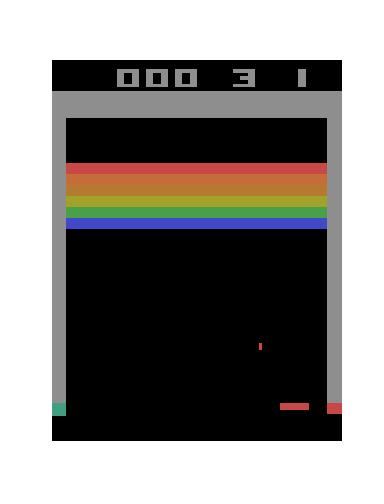
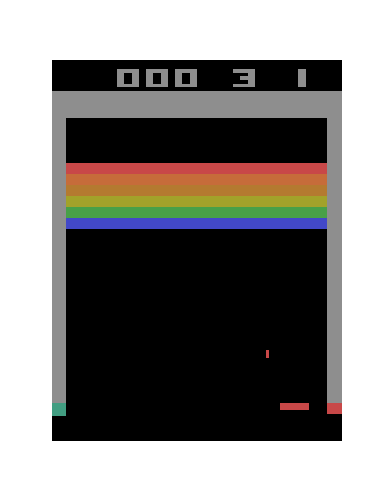
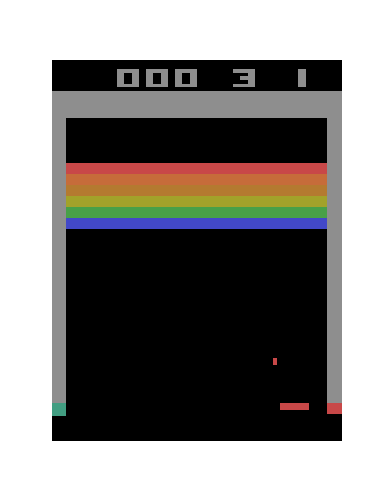
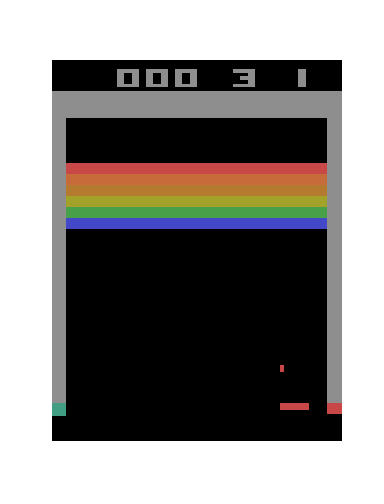
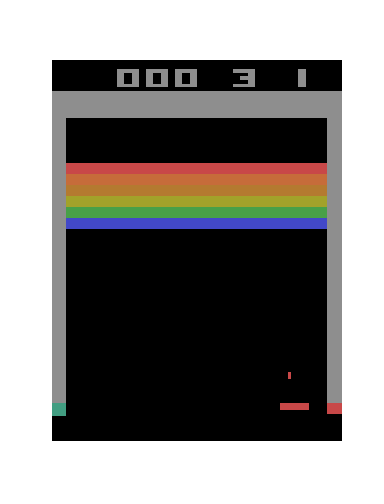
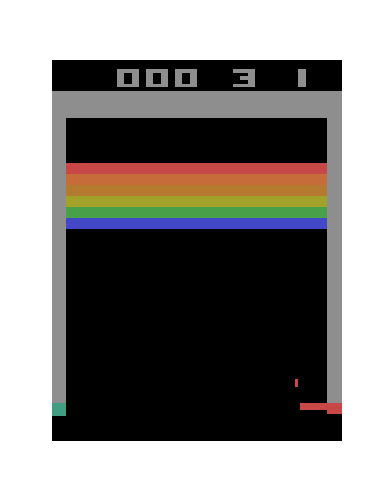
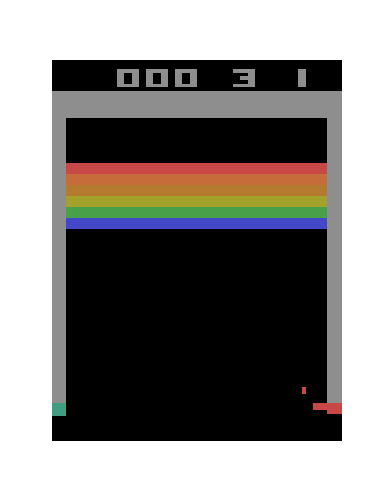
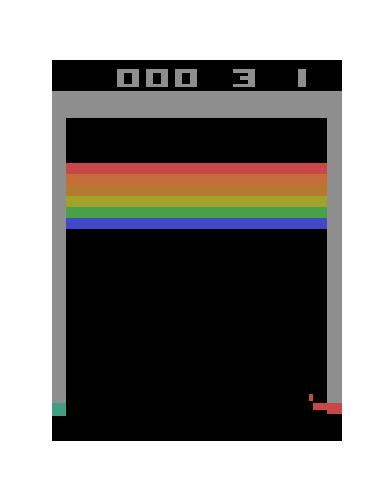
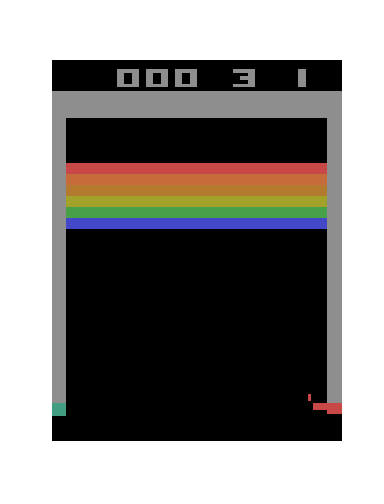
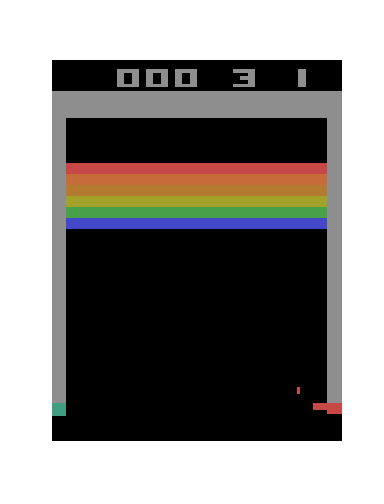
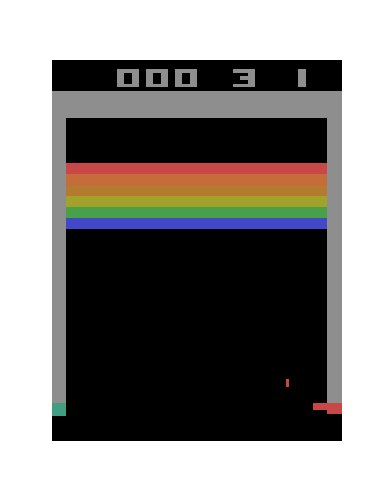
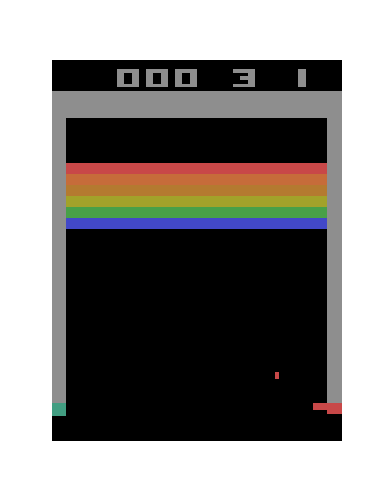
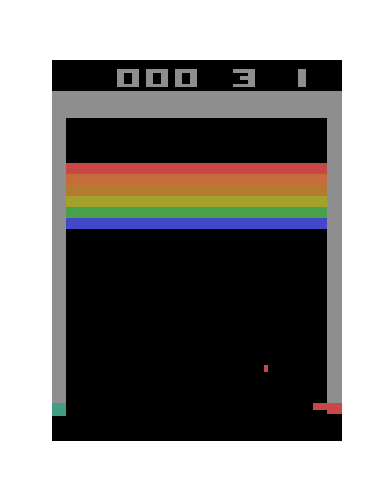
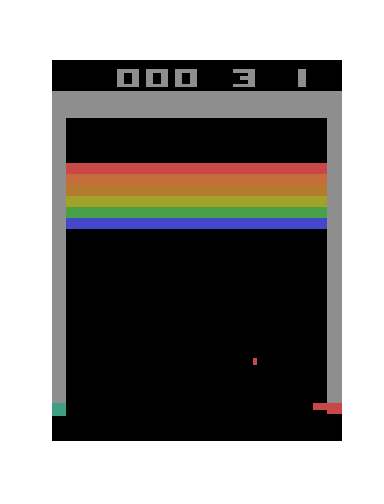
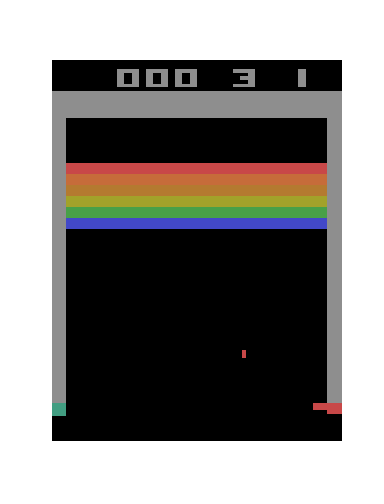
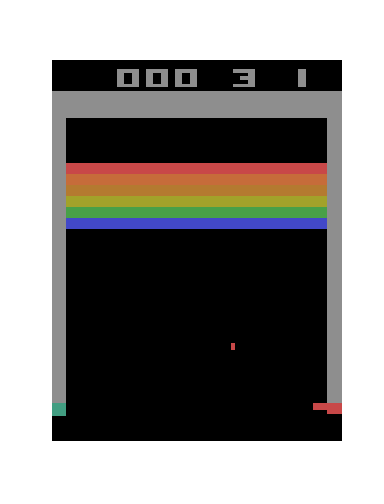
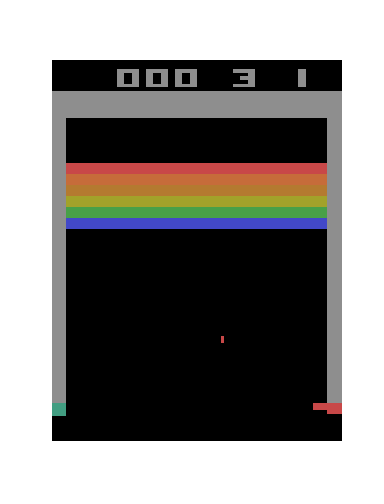
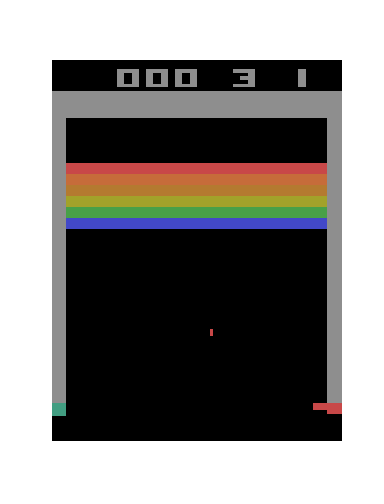
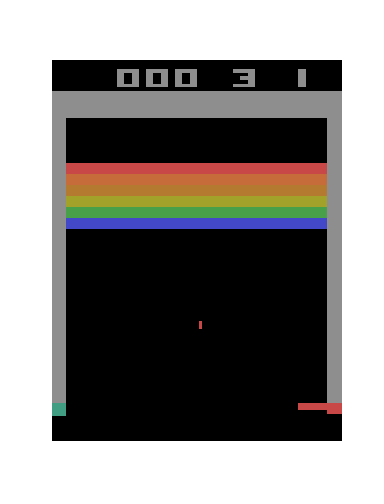
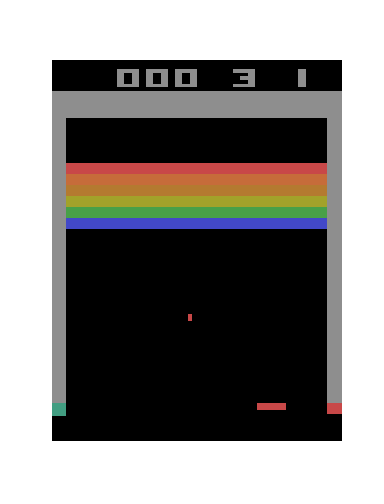
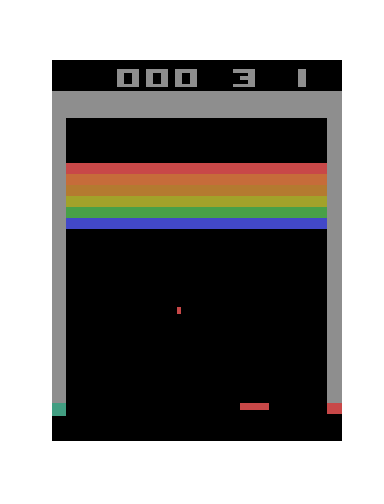
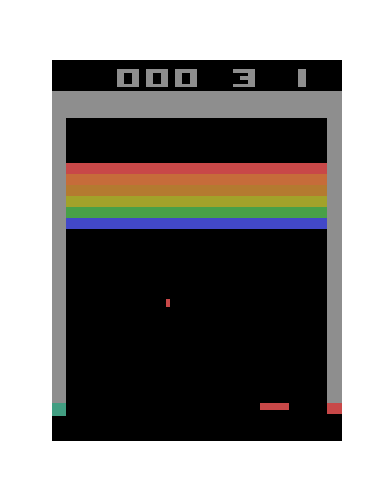
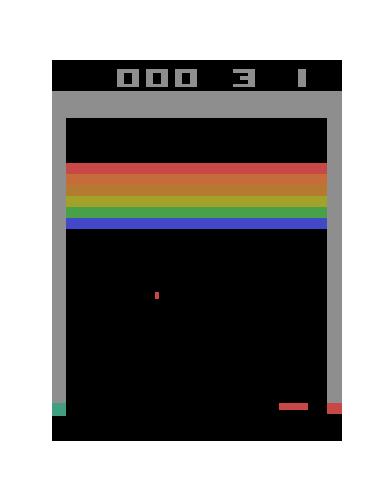
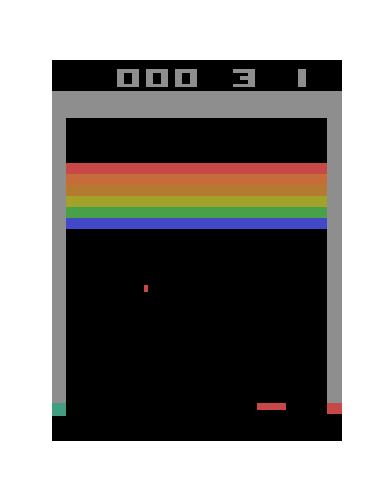
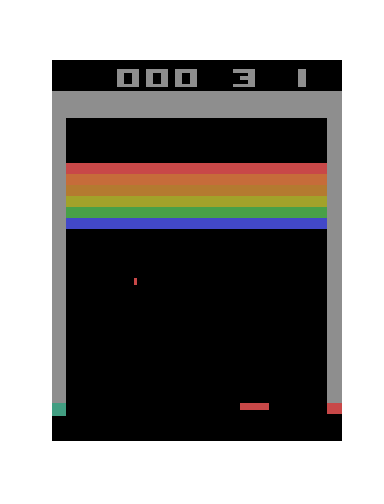
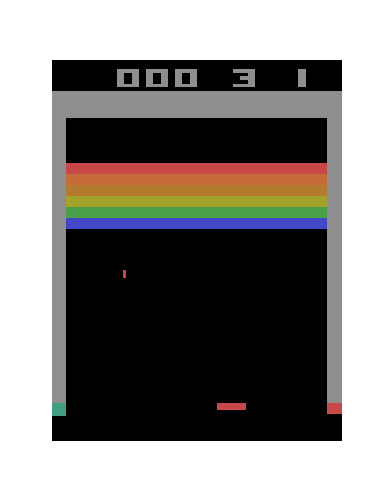
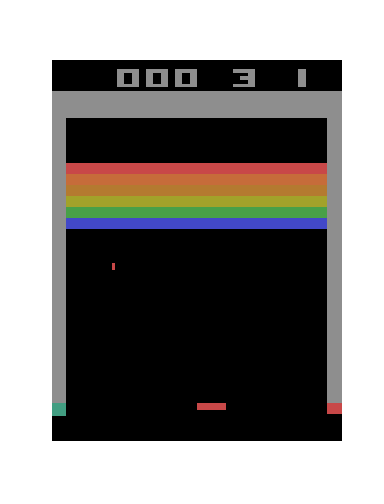
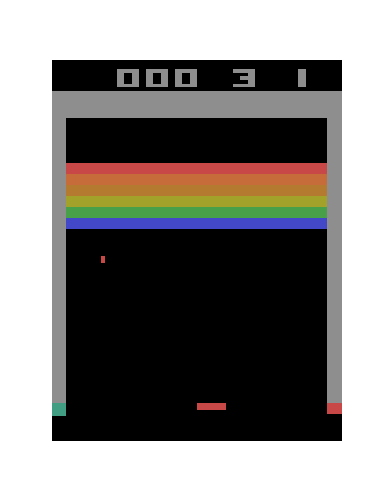
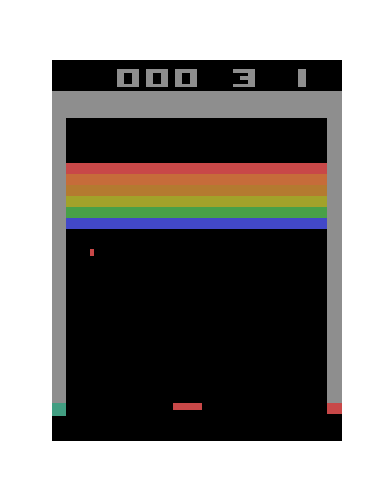
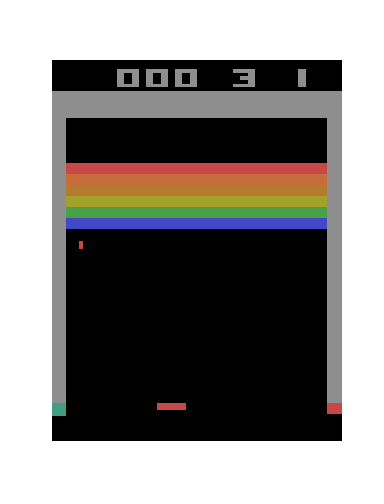
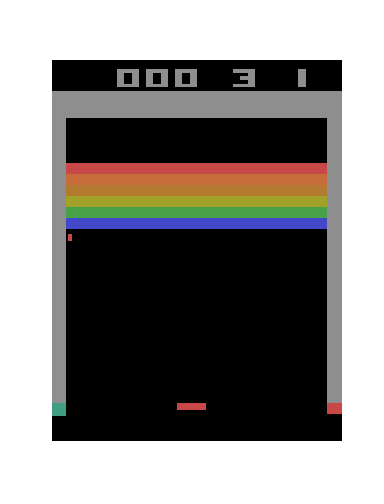
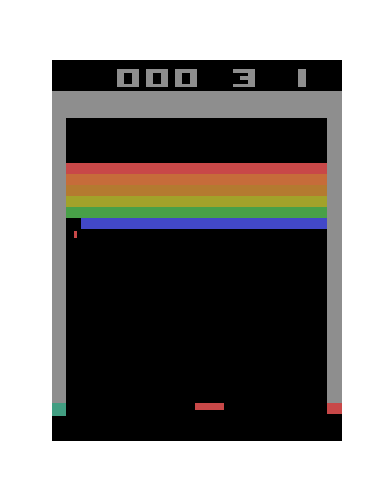
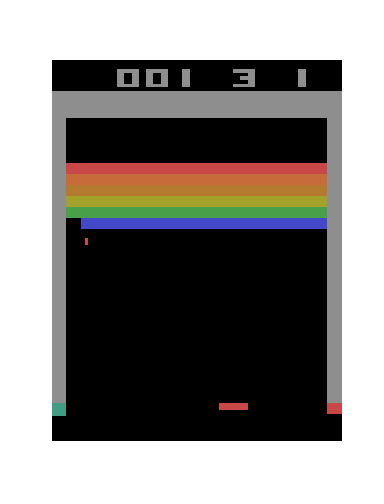
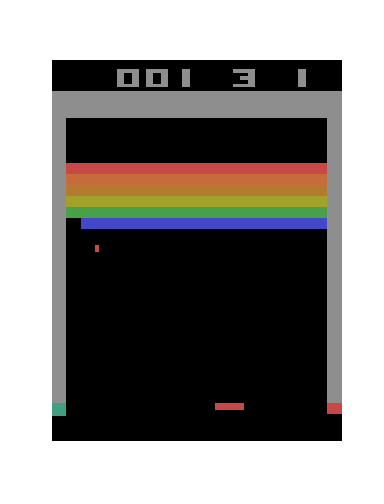
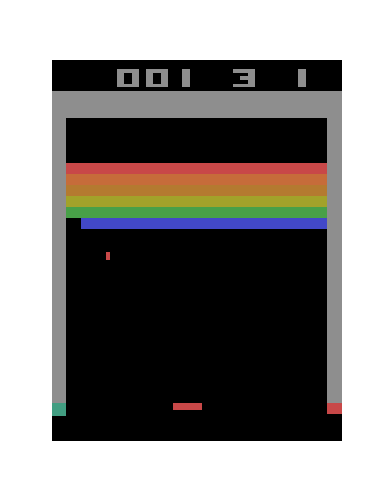
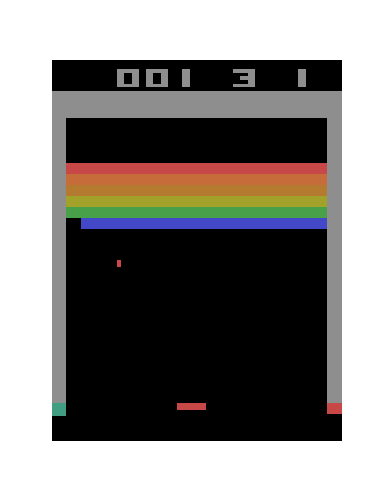
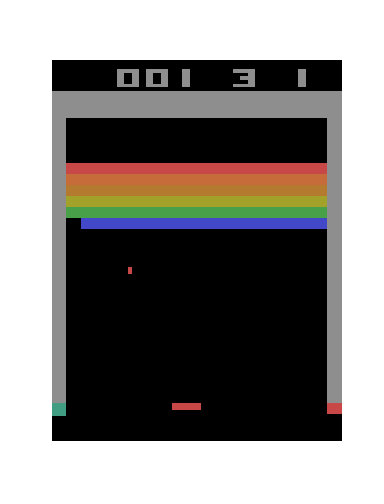
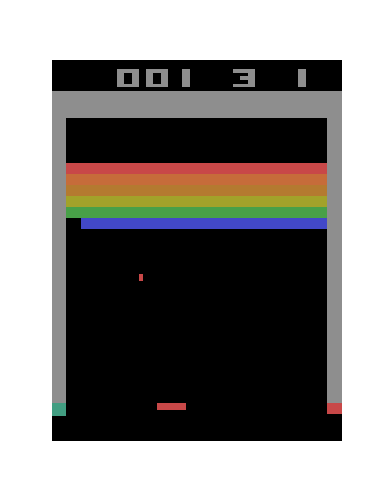
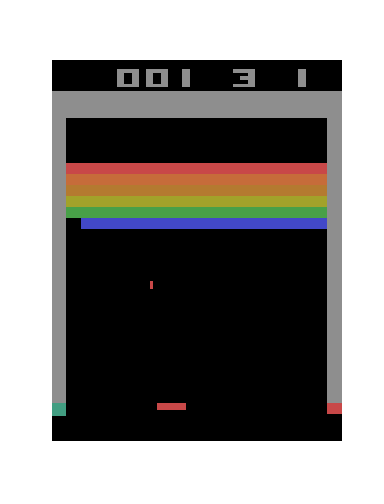
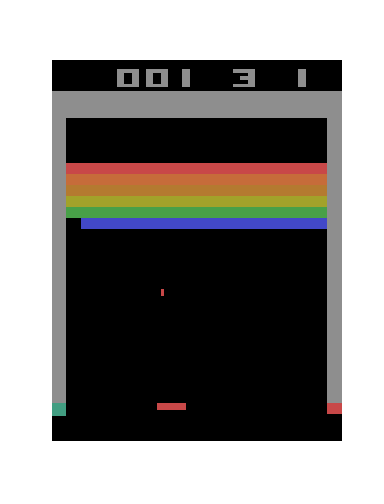
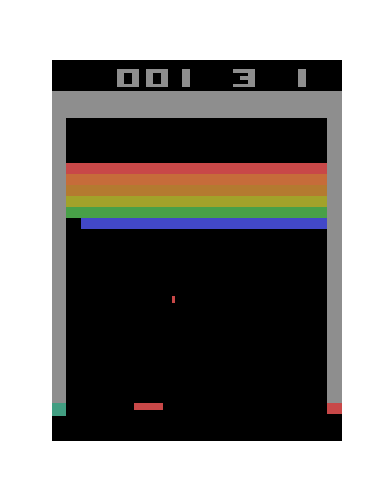
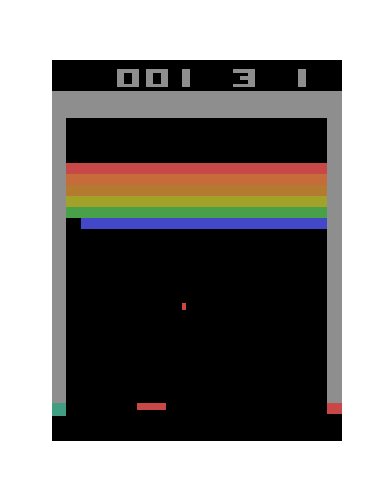
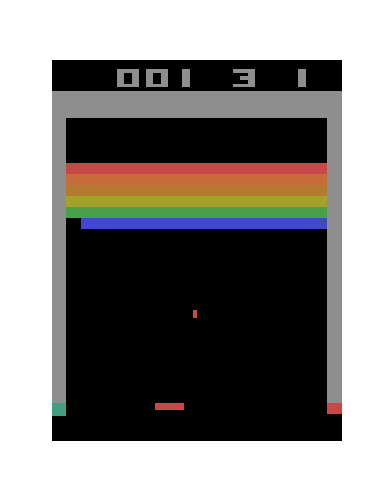
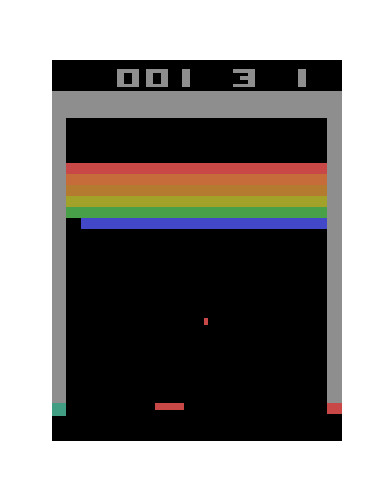
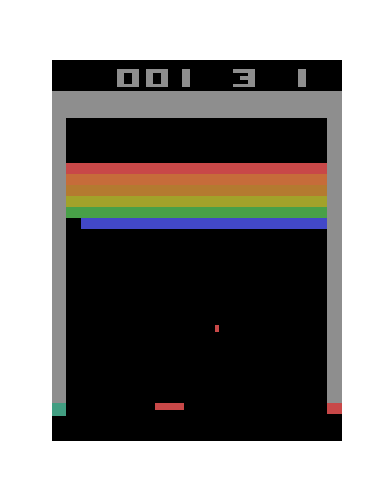
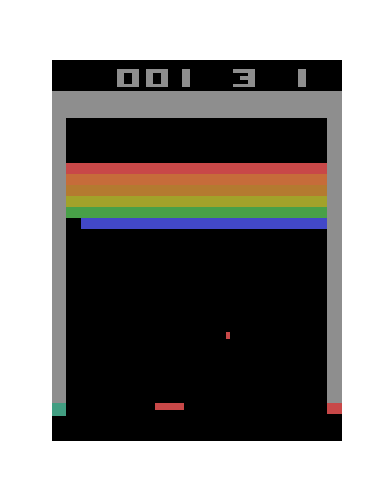
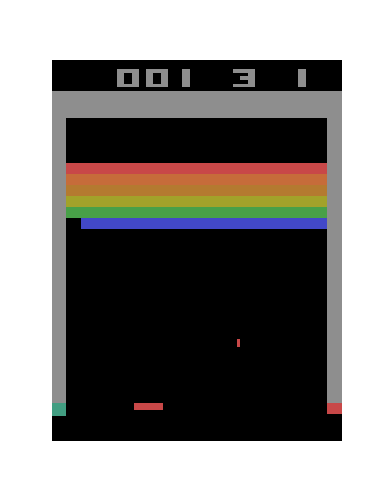
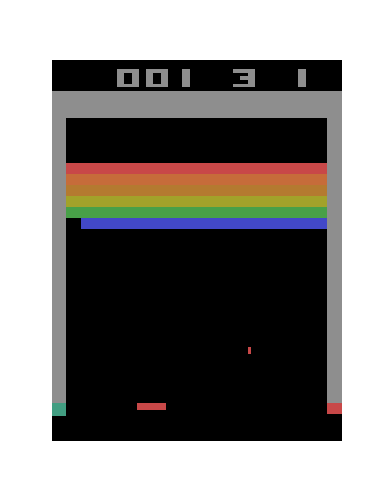
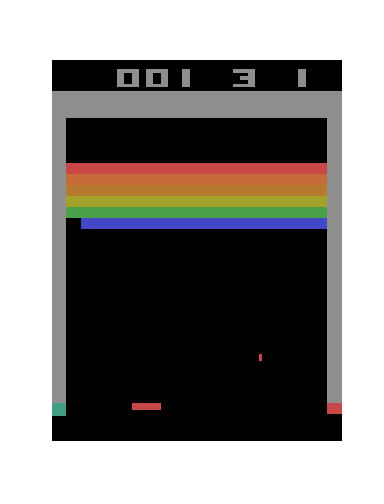
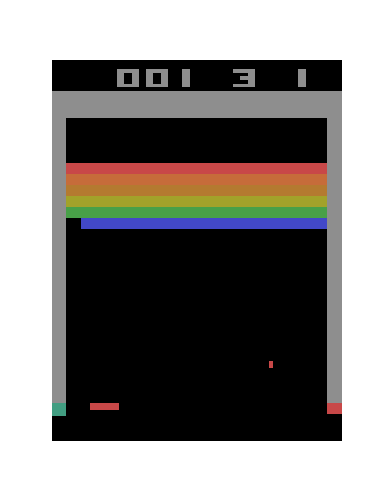
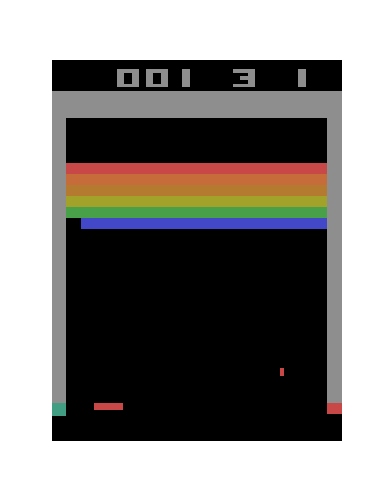
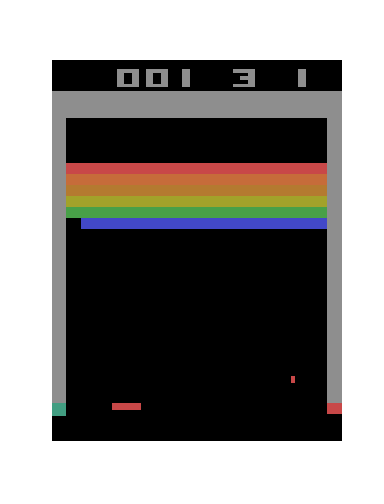
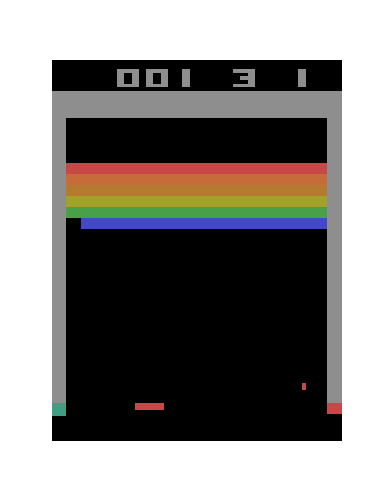
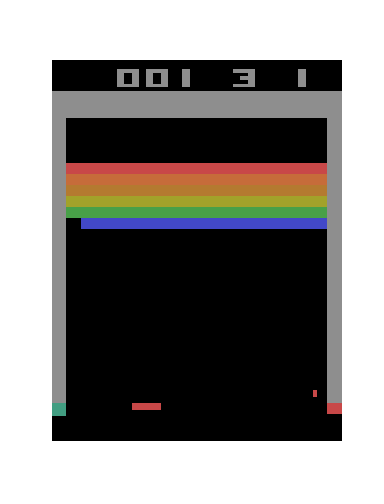
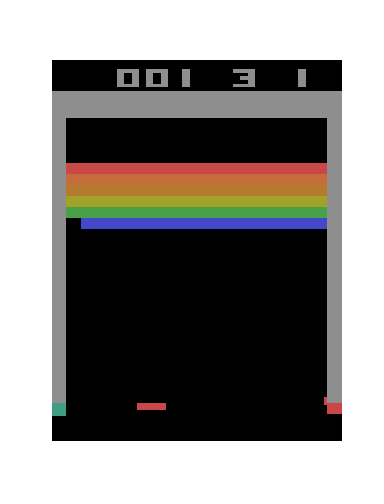
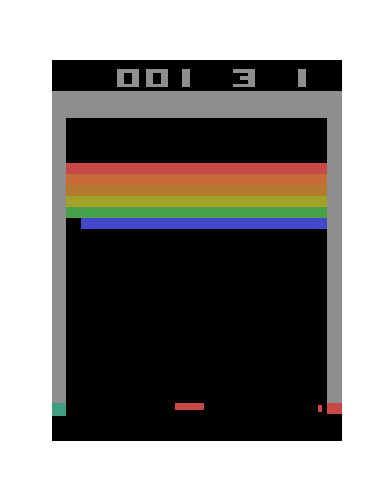
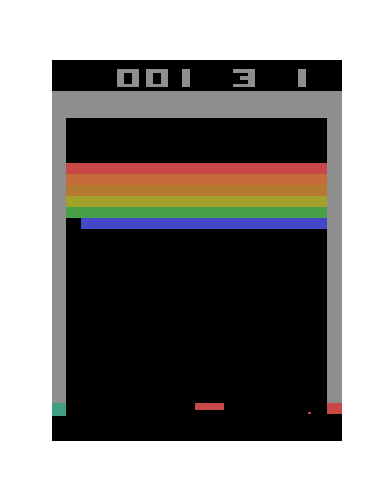
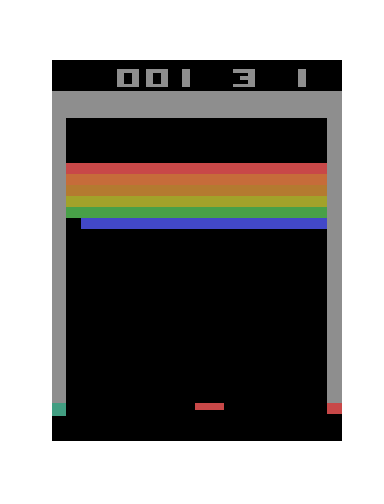
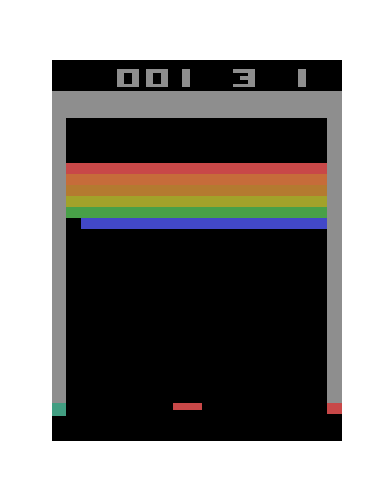
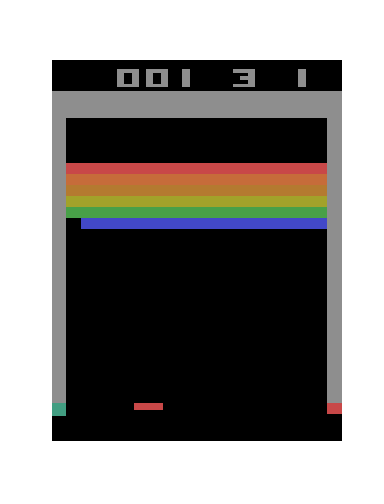
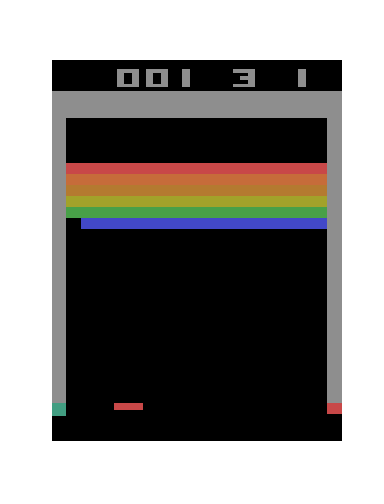
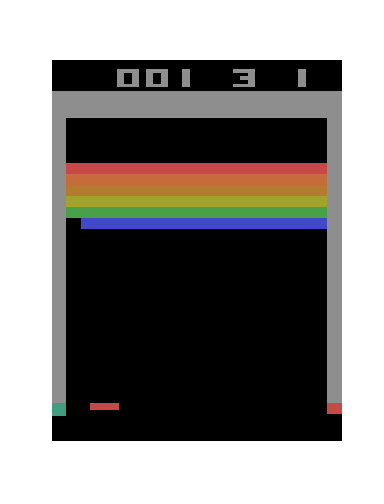
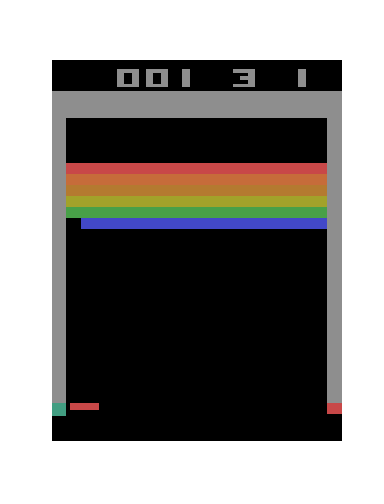
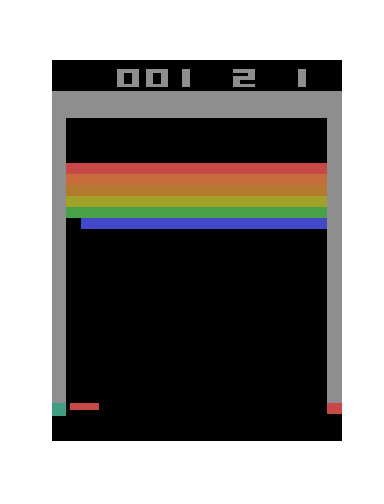
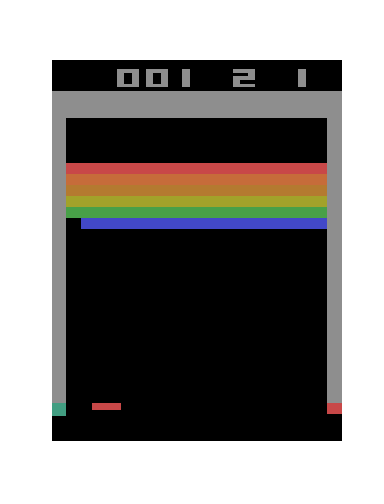
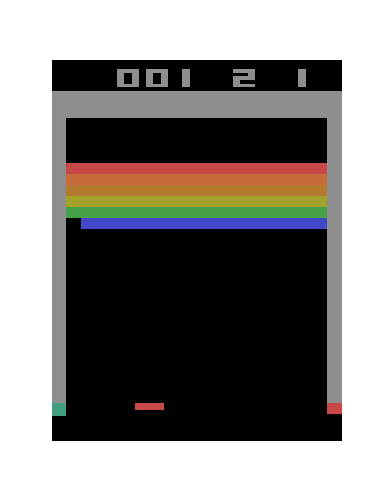
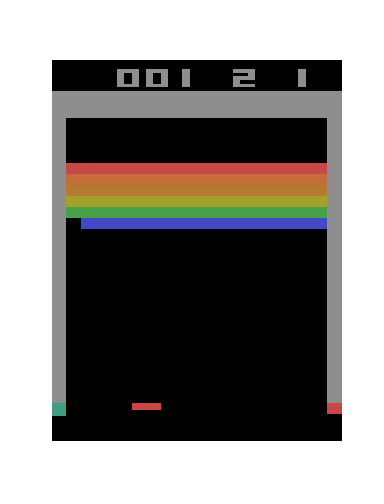
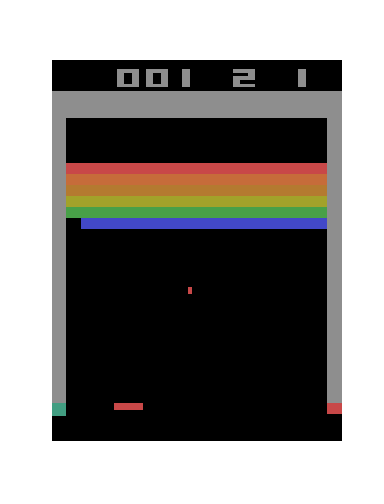
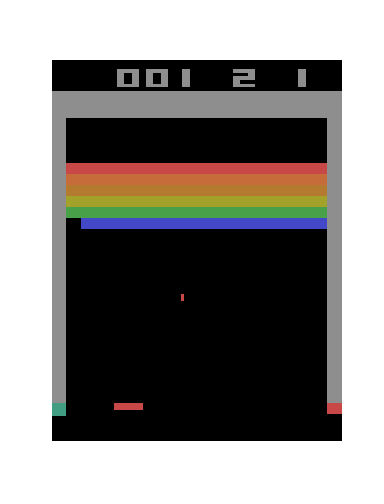
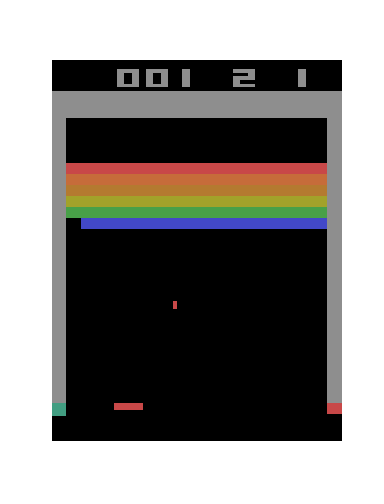
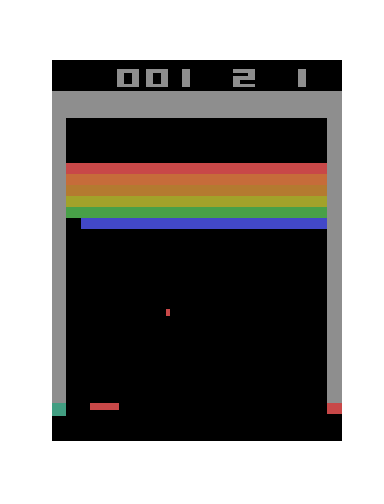
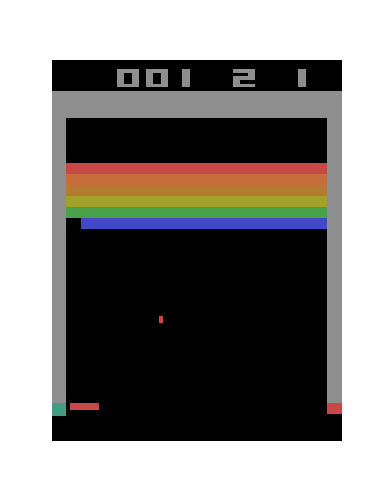
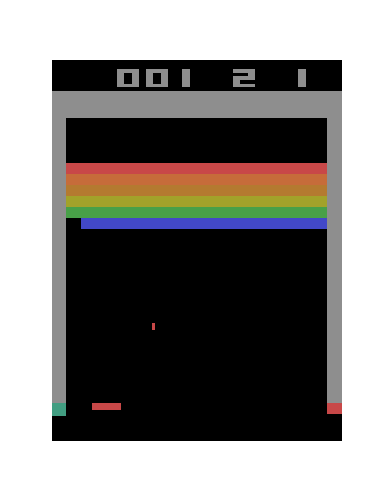
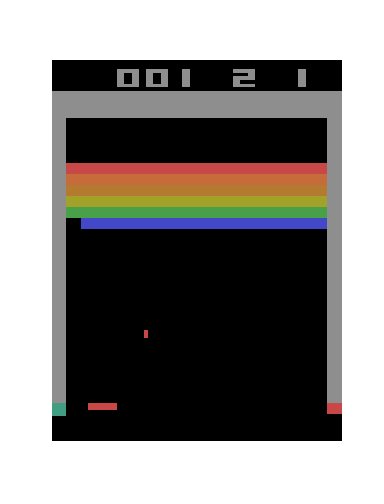
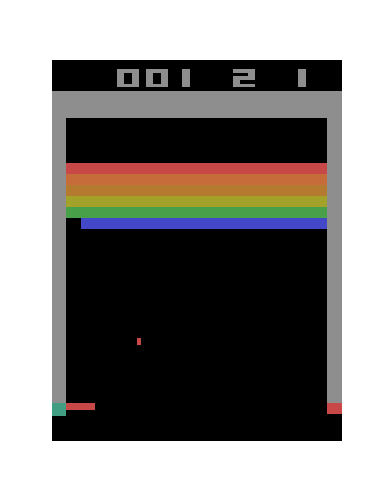
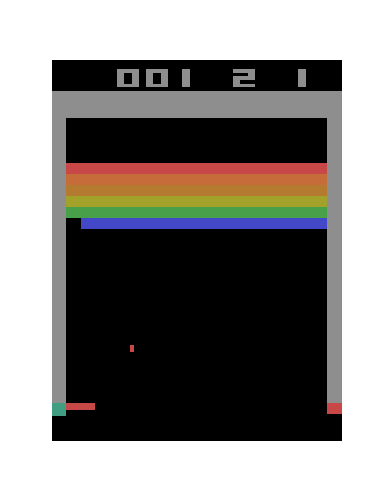
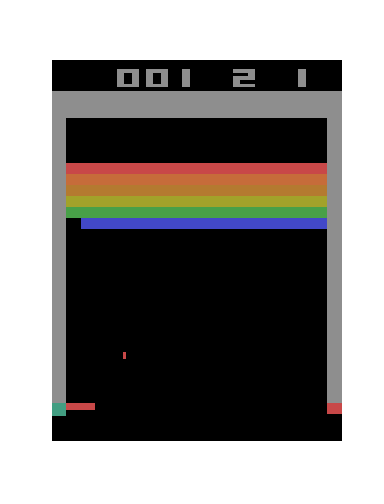
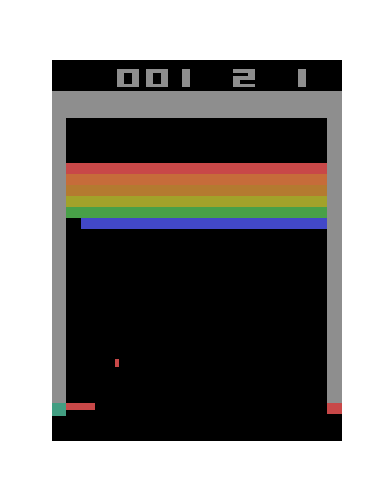
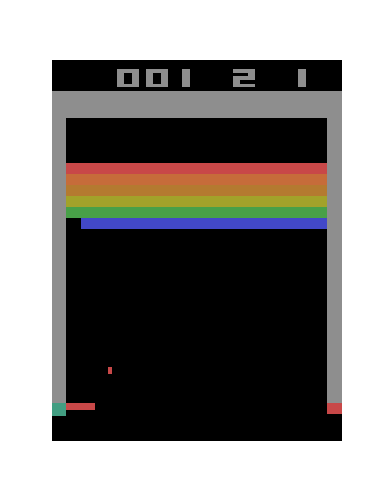
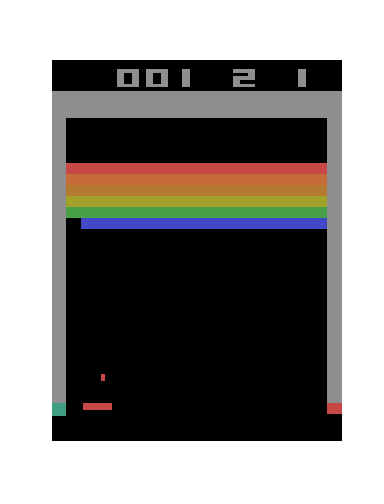
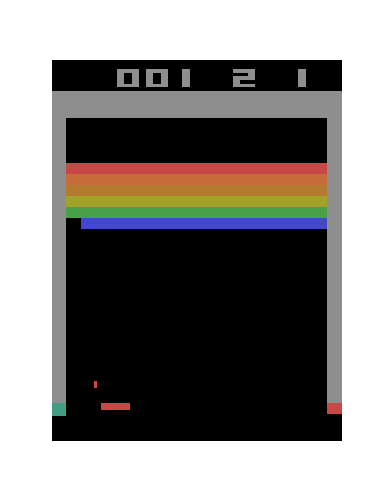
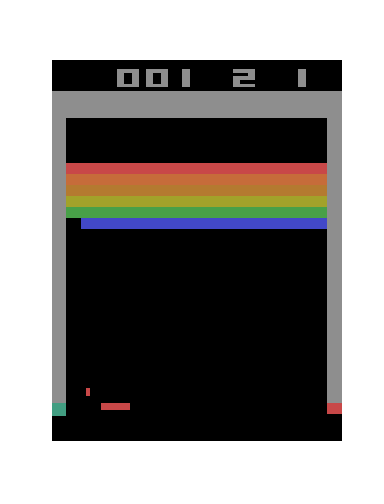
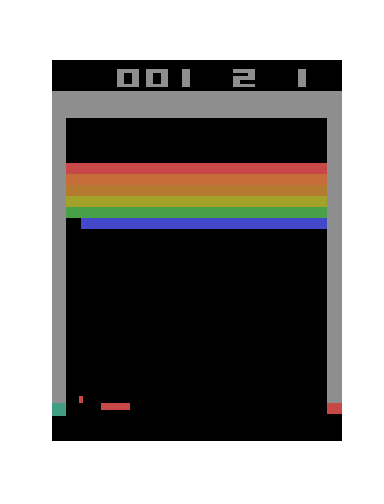
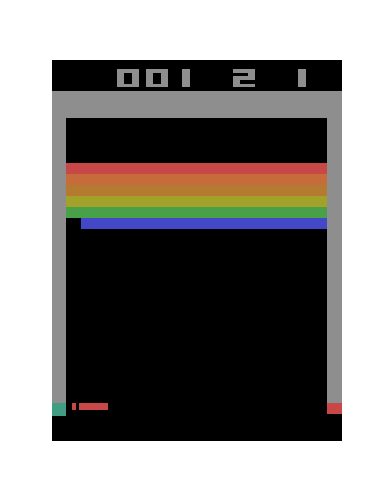
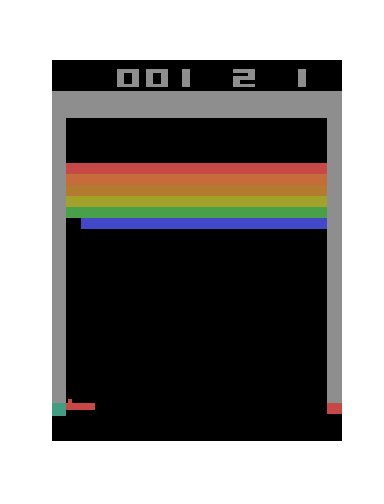
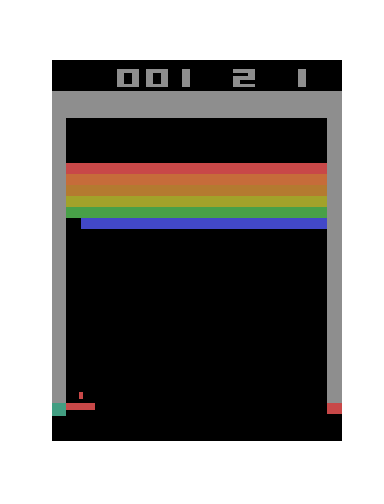
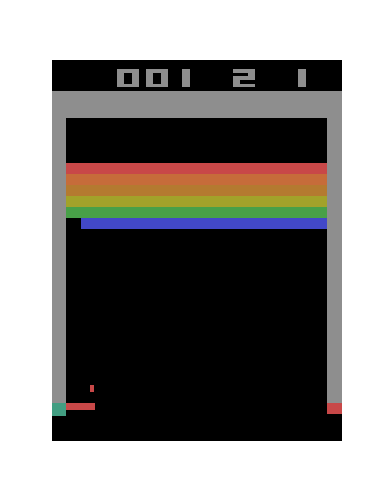
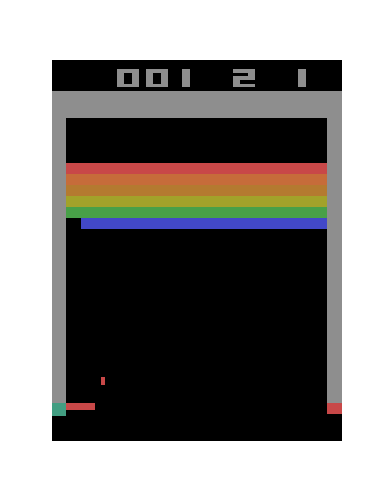
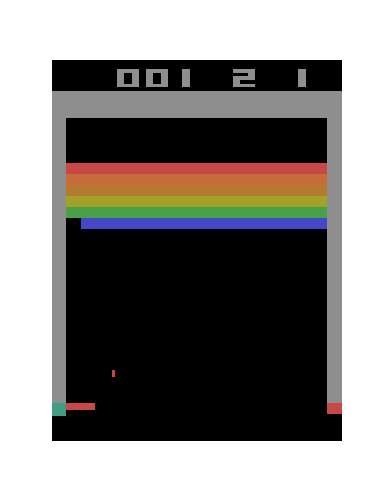
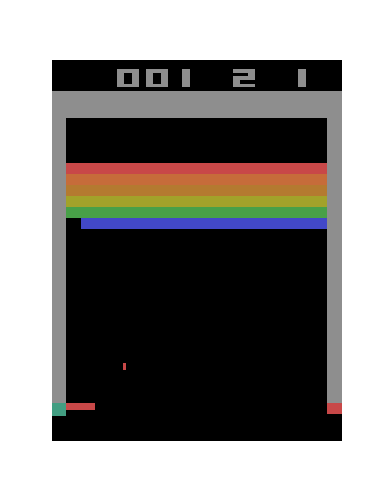
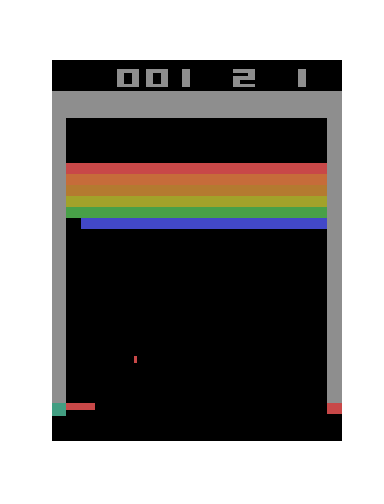
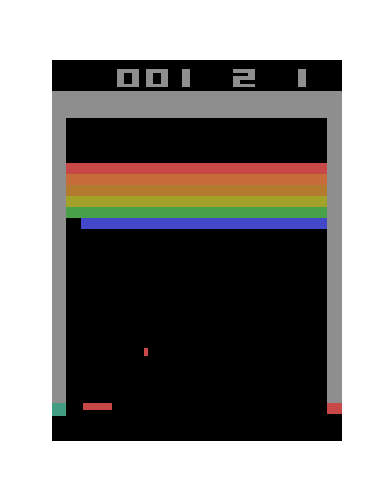
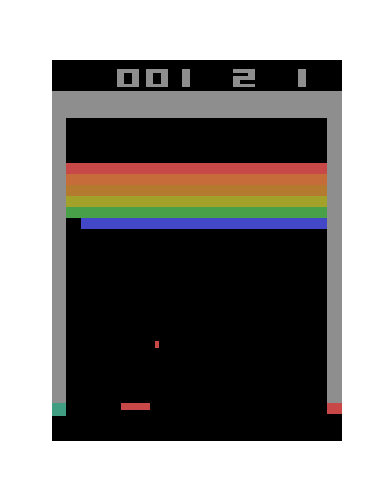
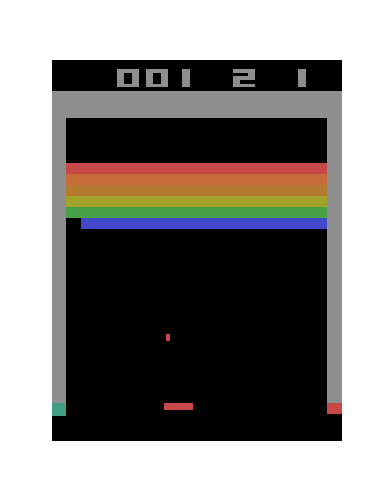
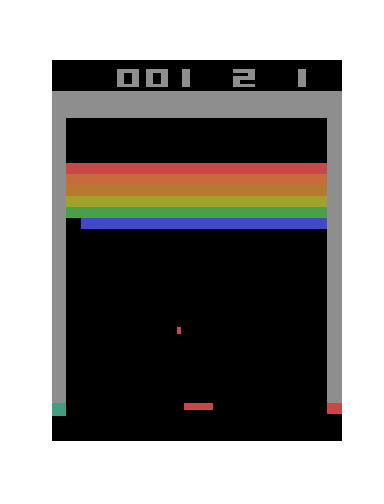
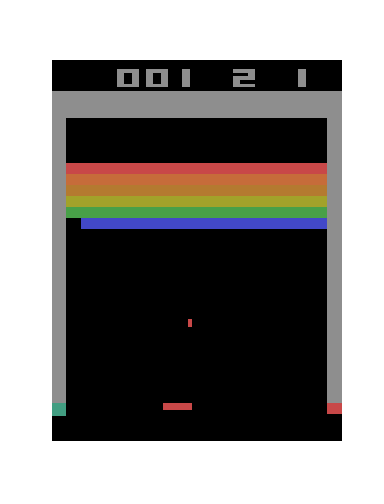
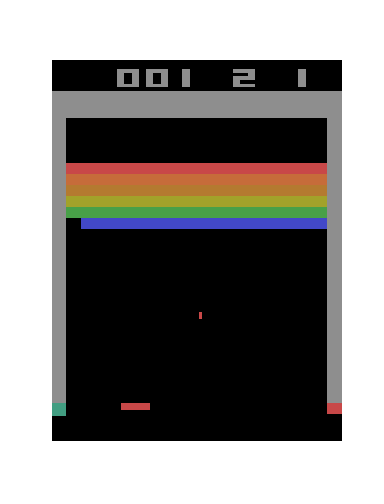
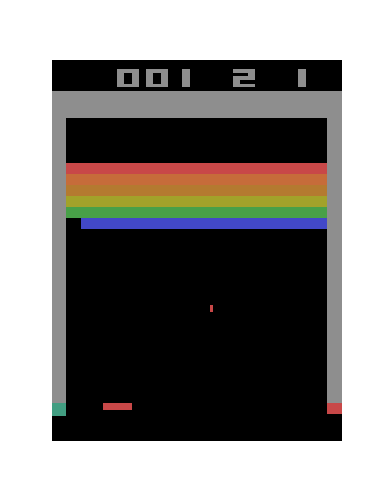
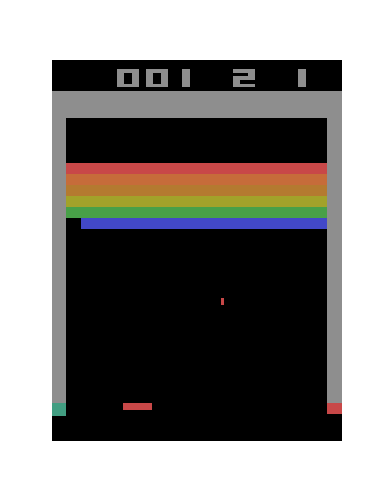
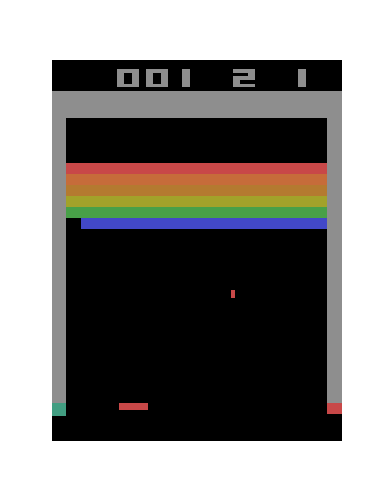
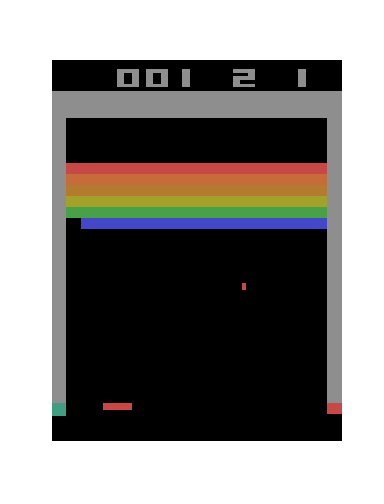
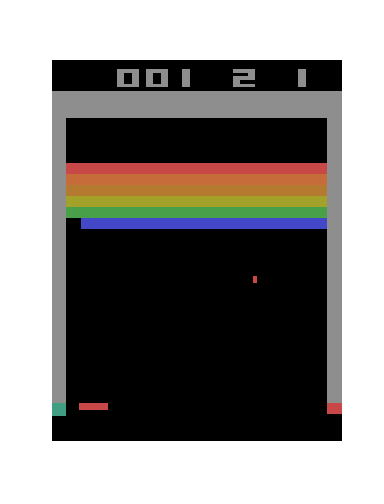
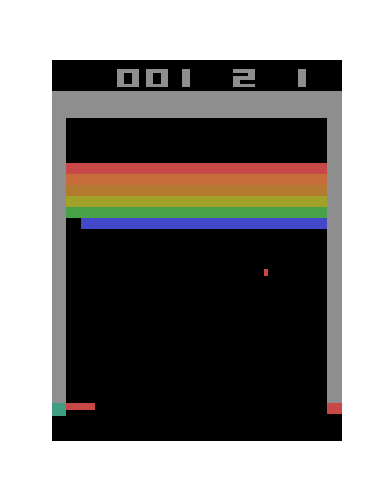
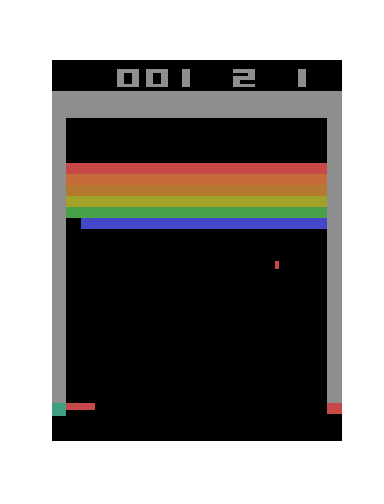
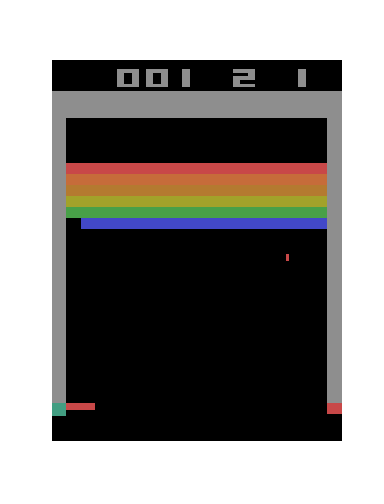
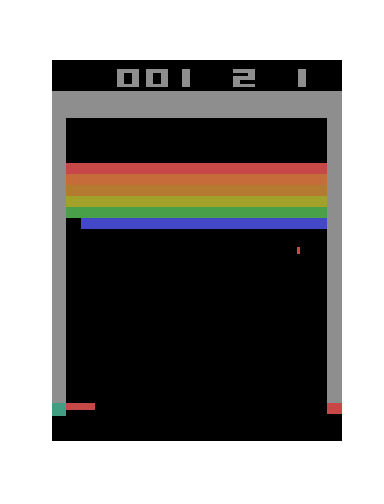
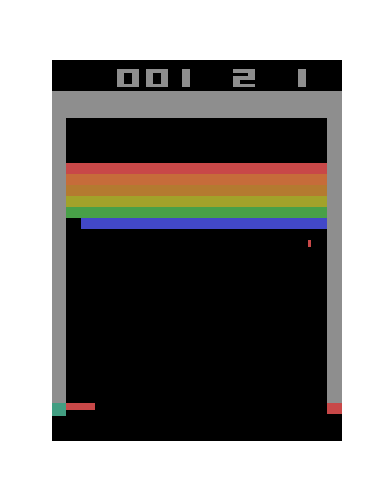
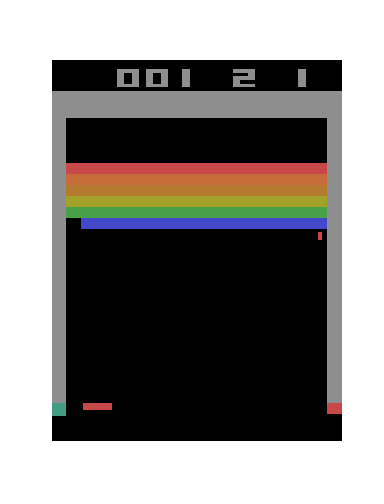
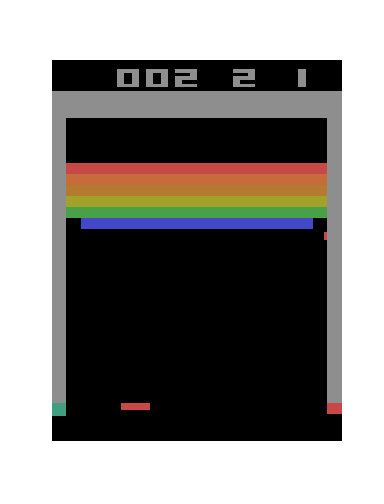
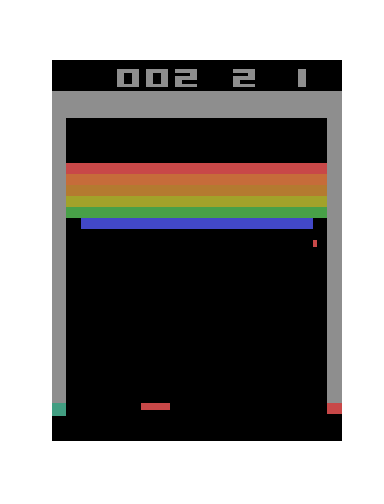
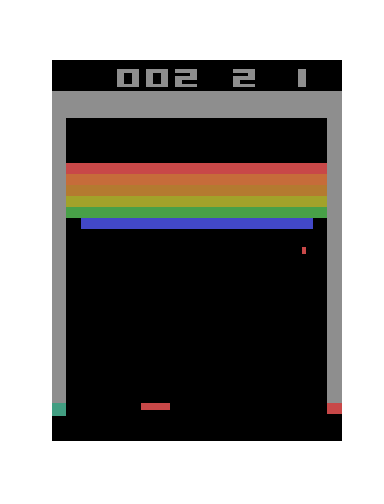
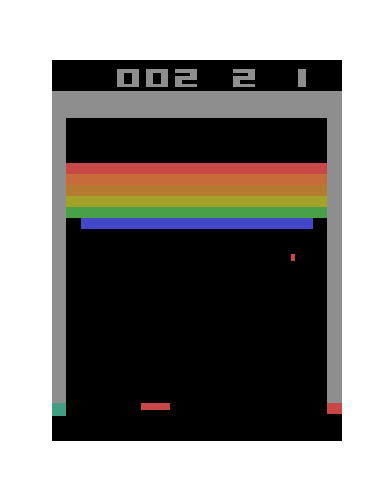
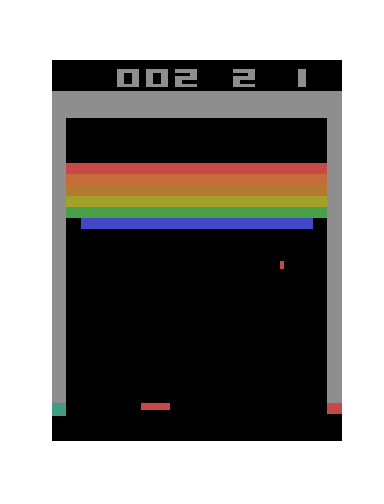
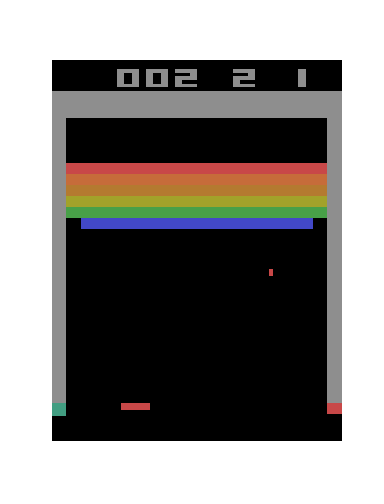
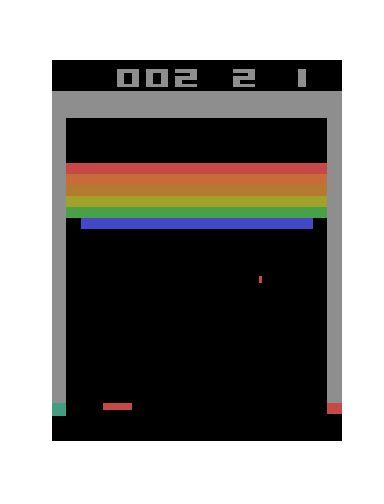
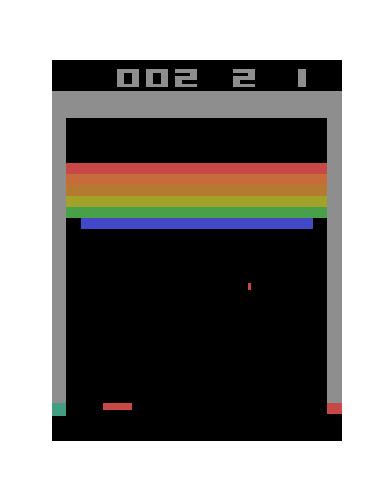
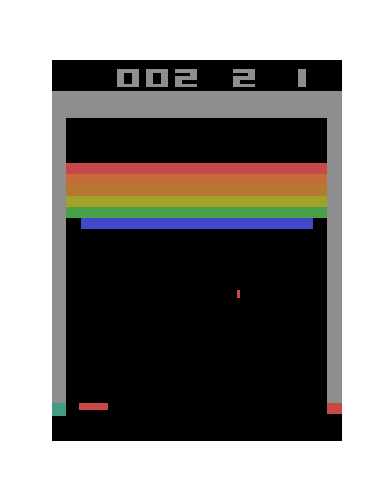
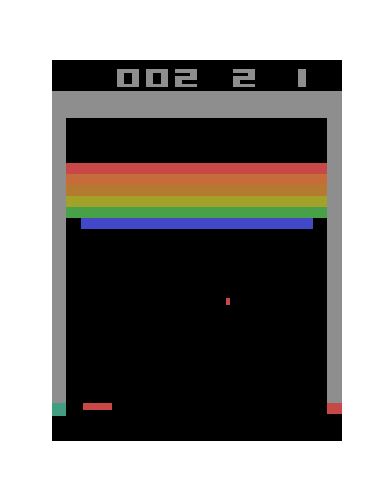
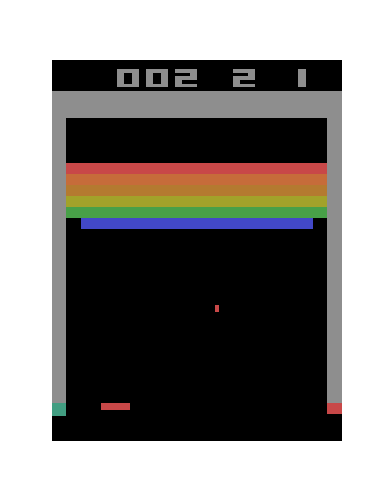
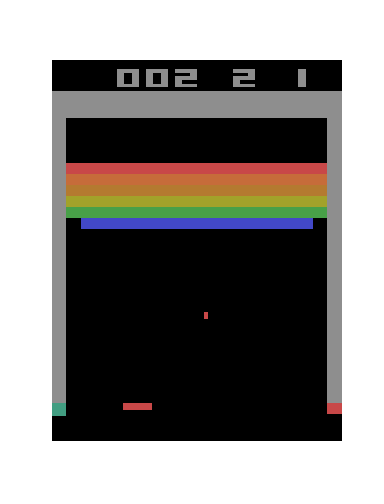
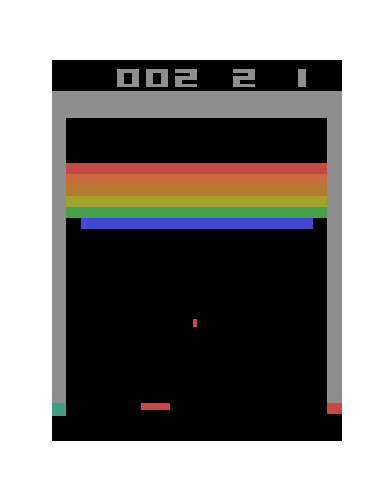
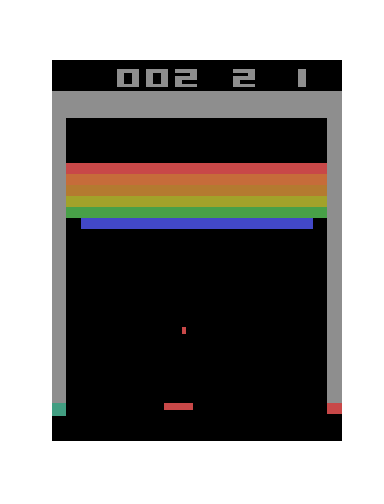
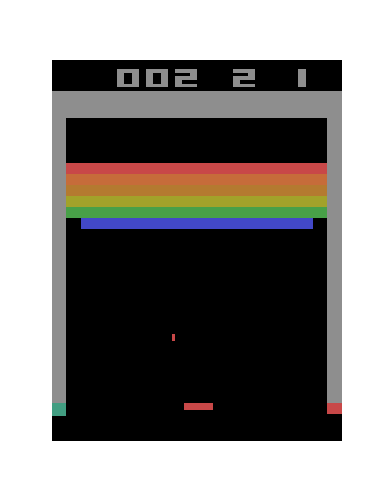
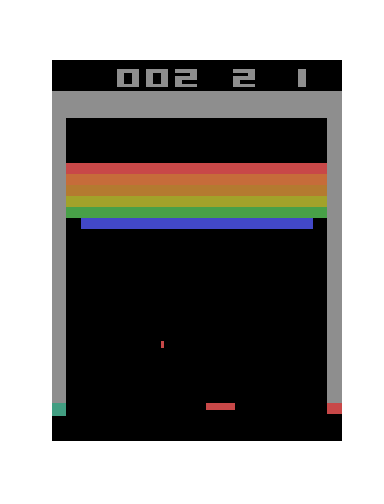
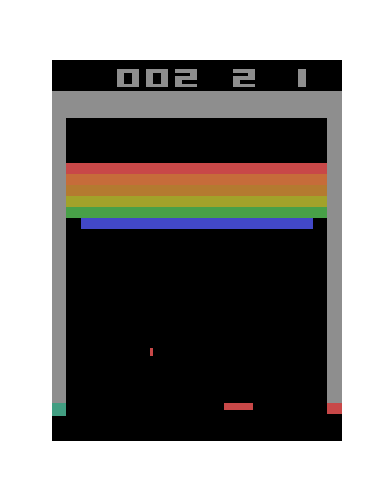
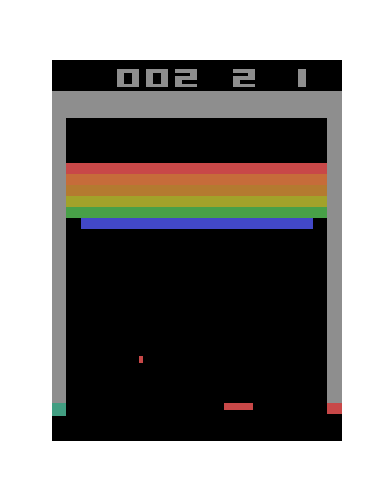
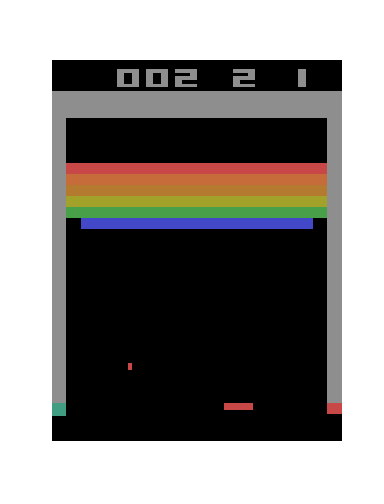
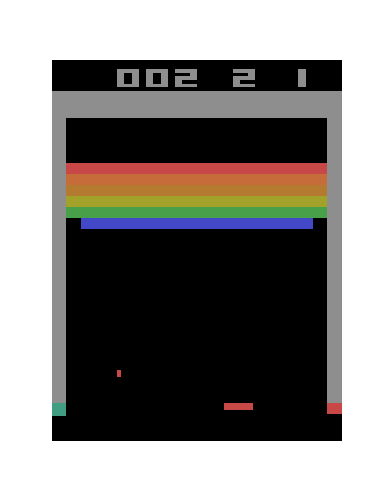
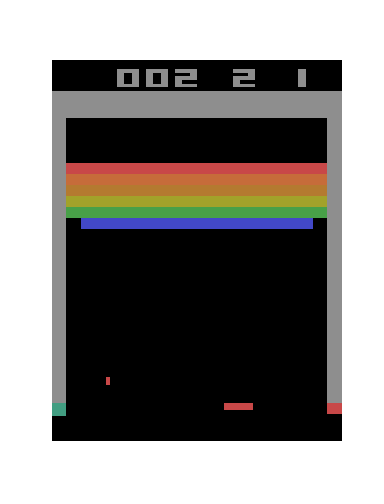
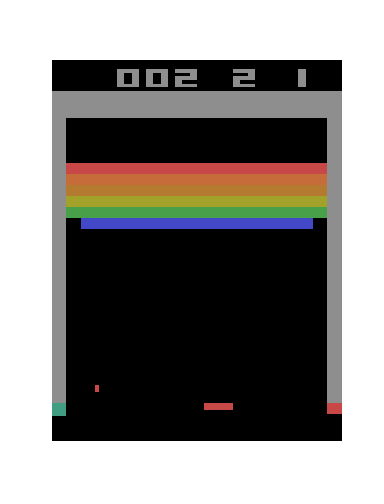
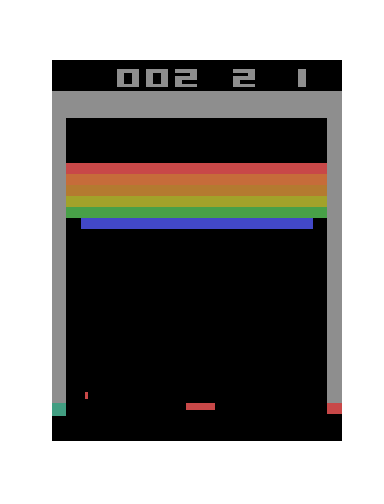
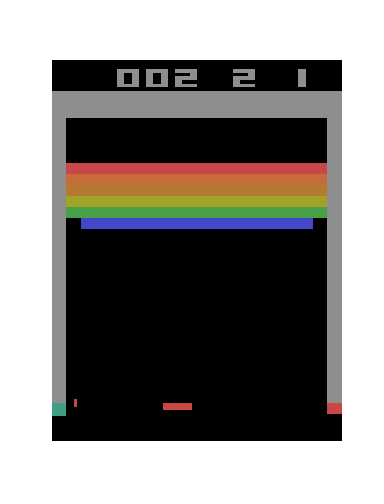
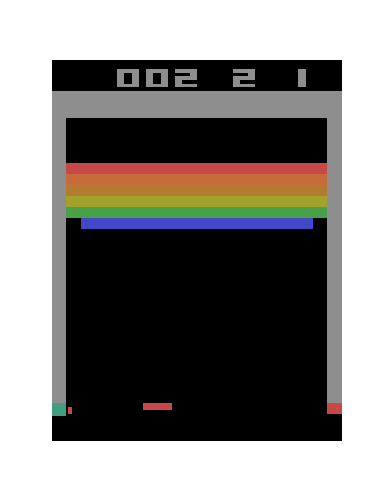
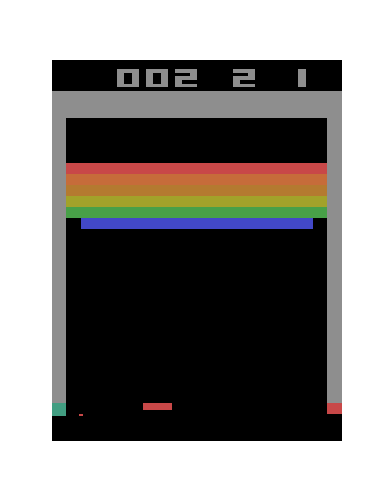
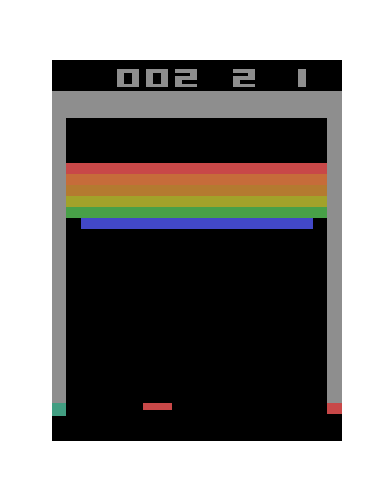
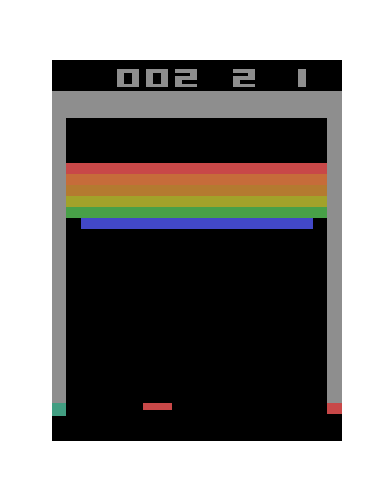
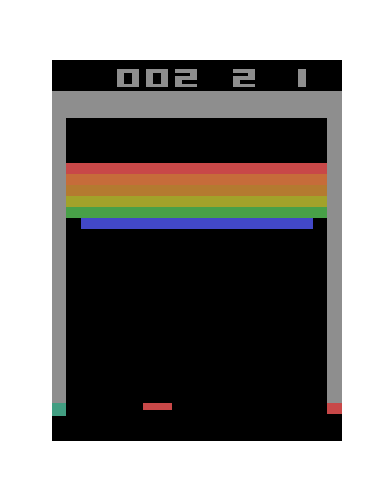
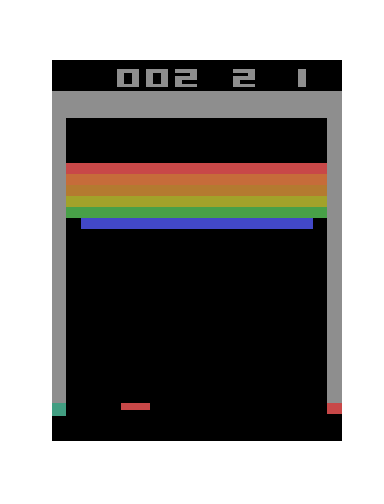
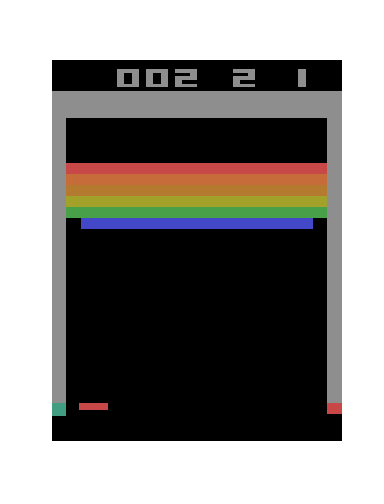
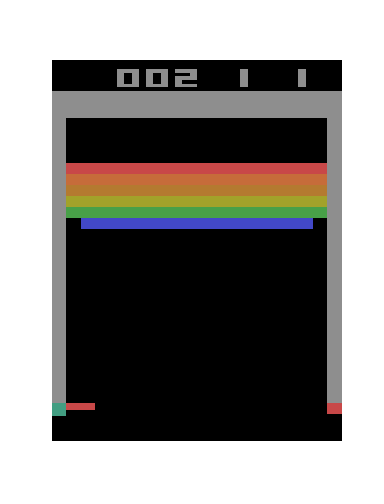
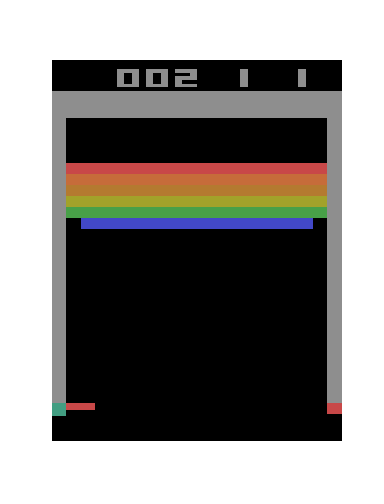
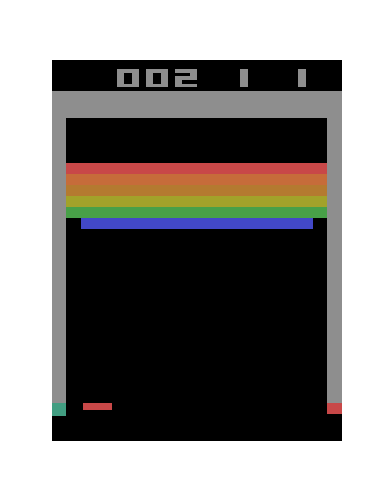
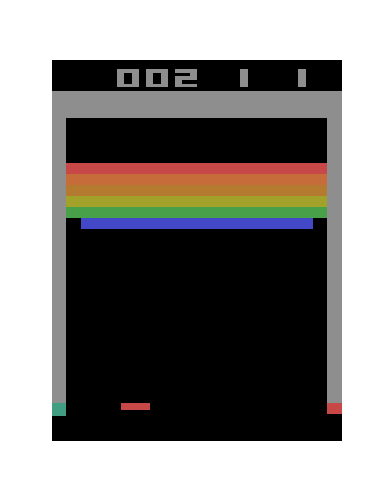
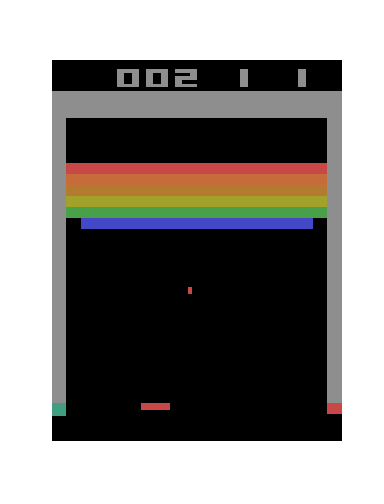
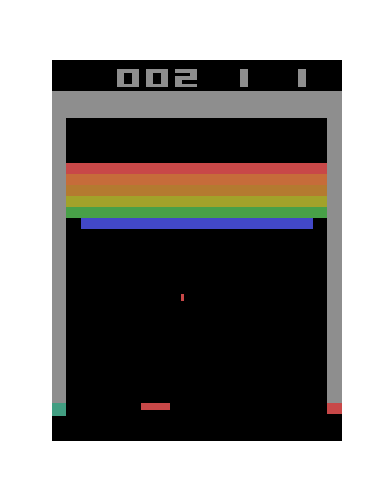
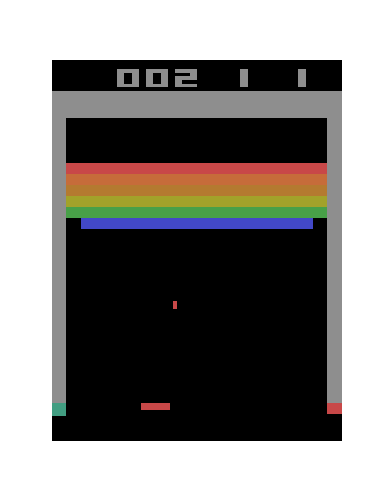
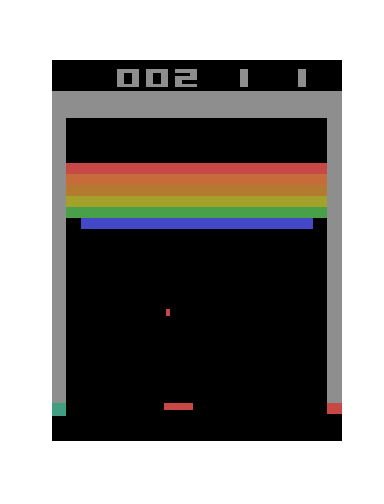
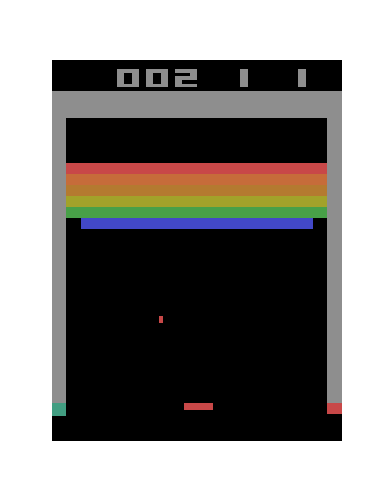
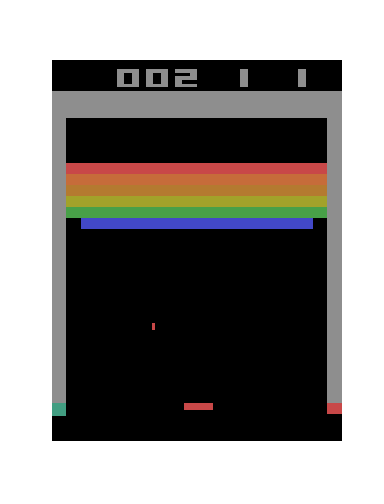
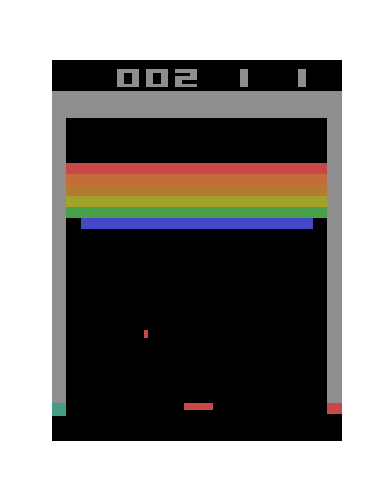
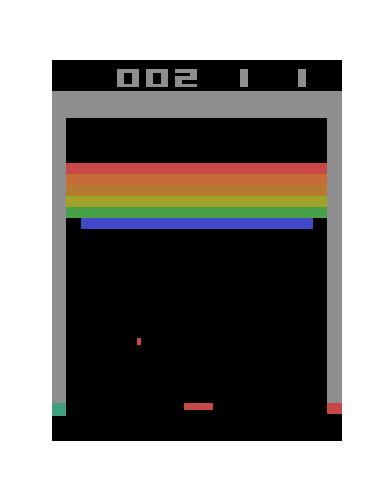
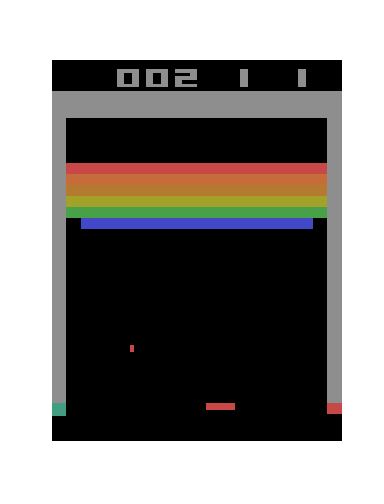
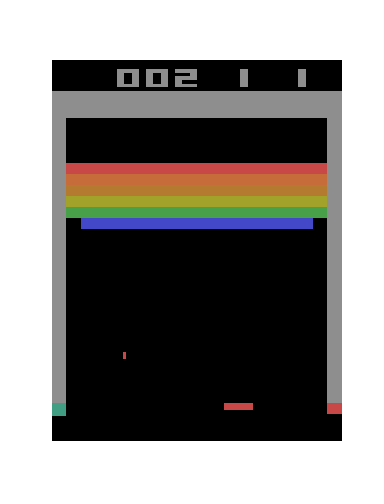
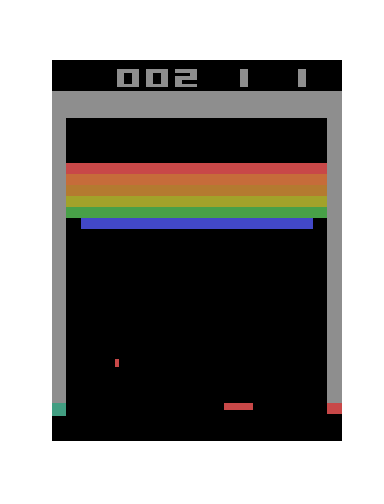
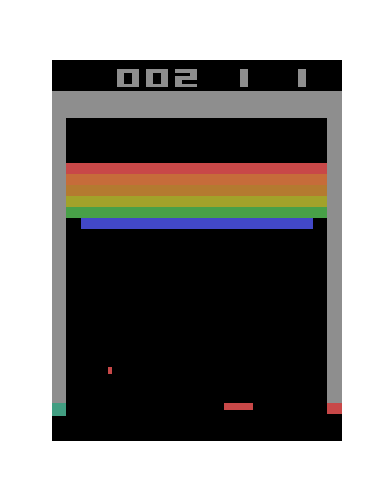
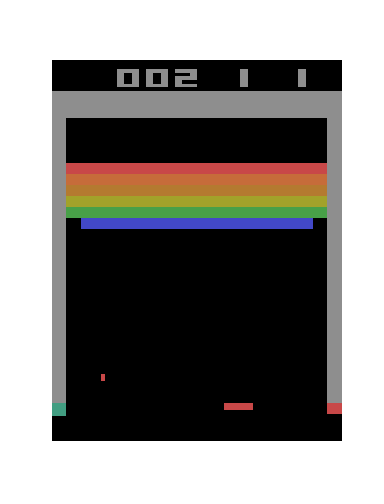
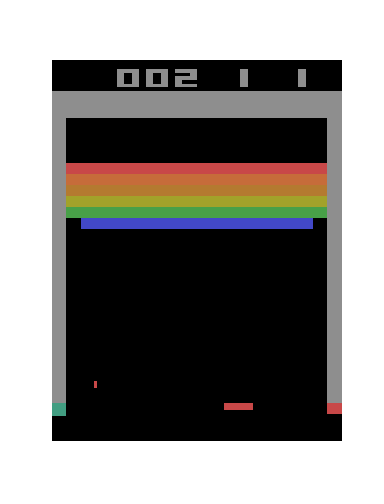
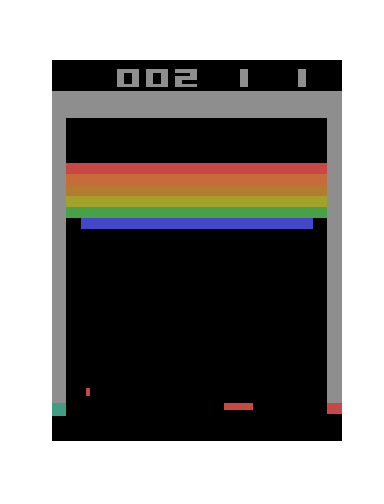
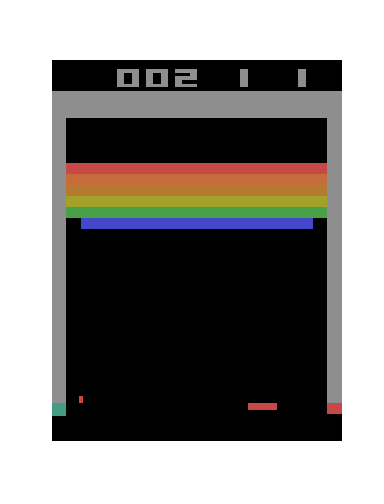
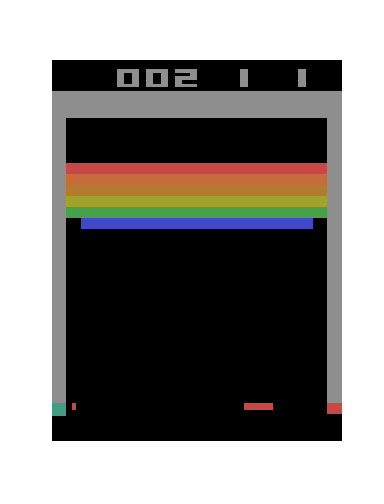
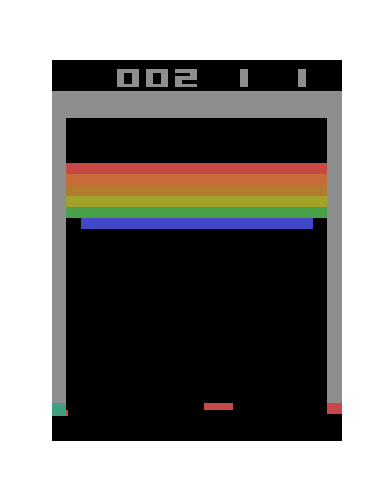
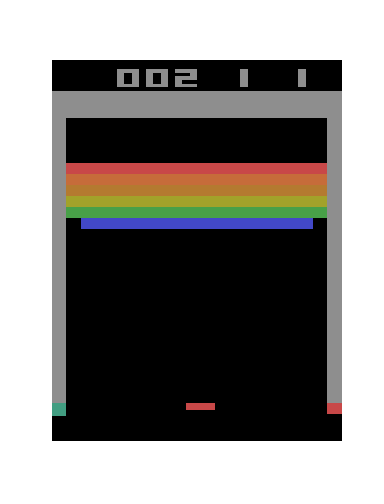
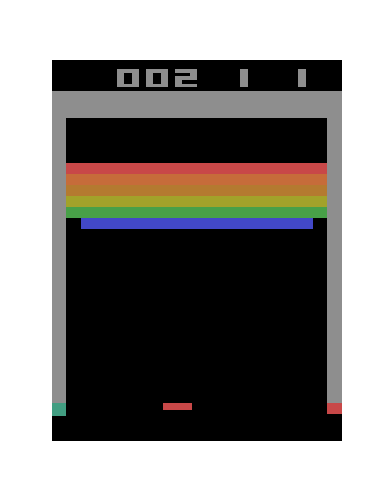
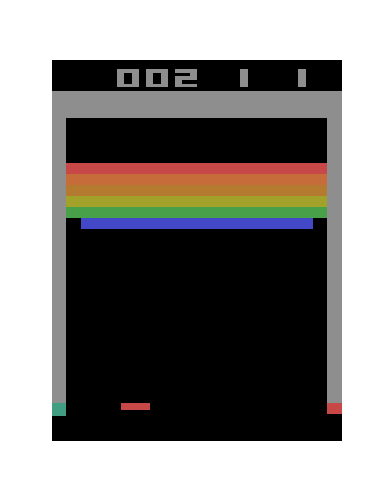
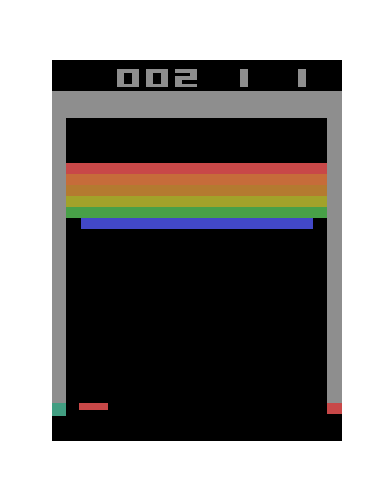
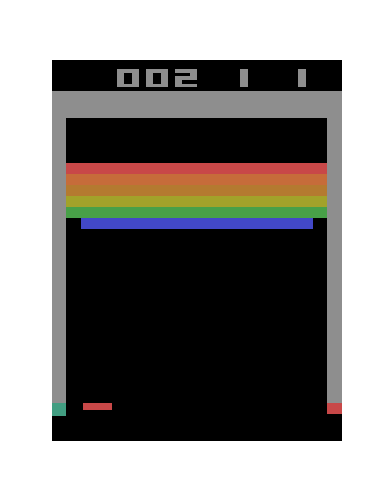
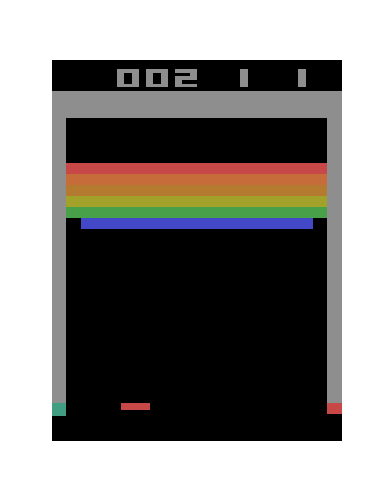

In [3]:
import gym

env = gym.make('BreakoutDeterministic-v4')

# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
done=False
while not done:
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

display_frames_as_gif(frames)

## Deep Q-Learning

### Goal
From the DeepMind [article](https://arxiv.org/pdf/1312.5602v1.pdf):
> We consider tasks in which an agent interacts with an environment E, in this case the Atari emulator,
in a sequence of actions, observations and rewards. At each time-step the agent selects an action
$a_t$ from the set of legal game actions, A = {1, . . . , K}. The action is passed to the emulator and
modifies its internal state and the game score. In general E may be stochastic. The emulator’s
internal state is not observed by the agent; instead it observes an image $x_t$ ∈ R
d
from the emulator,
which is a vector of raw pixel values representing the current screen. In addition it receives a reward
$r_t$ representing the change in game score. Note that in general the game score may depend on the
whole prior sequence of actions and observations; feedback about an action may only be received
after many thousands of time-steps have elapsed.

<img src="state_0.png">

### Terms
#### Actions
An action is a command given to the game to reach a certain state
-- Do nothing
"Do nothing", "ask for ball", left, right
#### State

#### Rewards

## Implementing Deep Q Neural Network with Keras

Qlearning

### Q-learning
#### Policy
#### Q function
$$Q(s,a)=r+\gamma max_{a}Q(s^{'},a^{'})$$

### Preprocessing

In [8]:
from PIL import Image
#INPUT_SHAPE = (84, 84, 4)


def preprocess(img):
    img_pil=Image.fromarray(img)
    #Downsample
    preprocessed_img_pil=img_pil.resize((84,84))
    #Convert to grayscale
    preprocessed_img_pil=preprocessed_img_pil.convert("L")
    #To Numpy array
    preprocessed_img=np.array(preprocessed_img_pil)
    #Change datatype to save storage space
    preprocessed_img=preprocessed_img.astype("uint8")
    #print(preprocessed_img.shape)
    preprocessed_img=np.reshape(preprocessed_img, (1,) + preprocessed_img.shape)

    return preprocessed_img

In [9]:
env = gym.make('BreakoutDeterministic-v4')

# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
done=False
while not done:
    # Render into buffer. 
    observation = env.render(mode = 'rgb_array')
    preprocessed = preprocess(observation)
    #print(preprocessed.shape)
    frames.append(preprocessed)
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
#np.shape(frames)
#display_frames_as_gif(frames)

## Stacking frames

In [ ]:
def stack_observations(stacked_frames, observation, is_new_episode):
    
    preprocessed_frame=preprocess(observation)
    #print(preprocessed_frame.shape)
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque(maxlen=4)

        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(preprocessed_frame)
        stacked_frames.append(preprocessed_frame)
        stacked_frames.append(preprocessed_frame)
        stacked_frames.append(preprocessed_frame)

        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=3)

    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(preprocessed_frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=3)

    #print(stacked_state.shape)
    return stacked_state, stacked_frames

## Exploration

In [3]:
def update_epsilon(iteration):
    a = (exploration_rate_max - exploration_min) / final_exploration_frame
    b = exploration_rate_max
    exploration_rate = np.max([b - a * iteration, exploration_min])

In [4]:
def act(state, global_step):
    if (np.random.uniform() < exploration_rate or global_step<=replay_start_step):
        return np.random.random_integers(0, action_size - 1)
    q_values = model.predict([state, np.ones(action_size).reshape(1, action_size)])
    return np.argmax(q_values)

## Model

In [11]:
from keras import backend as K

def huber_loss(a, b, in_keras=True):
    error = a - b
    quadratic_term = error * error / 2
    linear_term = abs(error) - 1 / 2
    use_linear_term = (abs(error) > 1.0)
    if in_keras:
        # Keras won't let us multiply floats by booleans, so we explicitly cast the booleans to floats
        use_linear_term = K.cast(use_linear_term, 'float32')
    return use_linear_term * linear_term + (1 - use_linear_term) * quadratic_term

In [13]:
from keras.layers import Conv2D, Flatten, Multiply
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.optimizers import Adam

input = Input(shape=input_shape, name='frames')
actions_input = Input((action_size,), name='mask')
normalized = Lambda(lambda x: x / 255.0)(input)
conv_1 = Conv2D(16, 8, 8, subsample=(4, 4), activation='relu')(normalized)
conv_2 = Conv2D(32, 4, 4, subsample=(2, 2), activation='relu')(conv_1)
conv_flattened = Flatten()(conv_2)
hidden = Dense(units=256, activation='relu')(conv_flattened)
output = Dense(output_dim=action_size, activation='linear')(hidden)
filtered_output = Multiply(name="Qvalue")([output, actions_input])
model = Model(input=[input, actions_input], output=filtered_output)
optimizer = Adam(lr=0.00001)
model.compile(optimizer=optimizer, loss=huber_loss)
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frames (InputLayer)             (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 84, 84, 4)    0           frames[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 16)   4112        lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 9, 9, 32)     8224        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 

C:\Users\cenarugu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), activation="relu", strides=(4, 4))`
  if __name__ == '__main__':
C:\Users\cenarugu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), activation="relu", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\cenarugu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=4)`
  del sys.path[0]
C:\Users\cenarugu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("Qv..., inputs=[<tf.Tenso...)`
  from ipykernel import kernelapp as app


## Experience Replay
### Remember


In [5]:
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

### Replay

In [16]:
import random
import numpy as np

def sample_train_batch():
    history = np.zeros(((batch_size,) + input_shape))
    next_history = np.zeros(((batch_size,) + input_shape))
    action = np.zeros((batch_size,), dtype="uint8")
    reward = np.zeros((batch_size,), dtype="uint8")
    done = np.zeros((batch_size,), dtype="bool")

    sample_batch = random.sample(memory, batch_size)
    for i in range(batch_size):
        history[i] = sample_batch[i][0]
        next_history[i] = sample_batch[i][3]
        action[i] = sample_batch[i][1]
        reward[i] = sample_batch[i][2]
        done[i] = sample_batch[i][4]

    return history, next_history, action, reward, done


In [7]:
from keras.utils import to_categorical
 
def train_replay(iteration):

    if len(memory) < batch_size:
        return

    target = np.zeros((batch_size, action_size))

    history, next_history, action, reward, done = sample_train_batch()
    next_targets = model.predict([next_history, np.ones((batch_size, action_size))])

    for i in range(batch_size):
        if done[i]:
            target[i][action[i]] = reward[i]
        else:
            target[i][action[i]] = reward[i] + gamma * np.amax(next_targets[i])

    action_one_hot=to_categorical(action, num_classes=action_size)
    target_one_hot = action_one_hot * target
    
    model.fit([history, action_one_hot], target_one_hot, batch_size=batch_size, epochs=1, verbose=0)

    update_epsilon(iteration)

C:\Users\cenarugu\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Hyperparameters

In [12]:
from collections import deque

env = gym.make('BreakoutDeterministic-v4')
state_size = env.observation_space.shape
action_size = env.action_space.n

input_shape = (84, 84, 4)
batch_size = 32

learning_rate = 0.001
gamma = 0.99

sum_q_max, sum_loss = 0, 0

# parameters about epsilon
exploration_rate_max, exploration_min = 1.0, 0.1
exploration_rate = exploration_rate_max

final_exploration_frame = 1000000
memory = deque(maxlen=10000)
n_stacked_frames = 4

# model
target_model = None
target_model_update_iteration = 10000

## Putting All together

## Training

In [14]:
from enum import Enum

class STATUS(Enum):
    OBSERVING = 1
    EXPLORING = 2
    TRAINING = 3

def getStatus():
    if global_step <= replay_start_step:
        return STATUS.OBSERVING
    elif global_step <= (replay_start_step + final_exploration_frame):
        return STATUS.EXPLORING
    else:
        return STATUS.TRAINING

In [19]:
import logging as log
import time
import traceback
log.basicConfig(level=log.INFO)

episodes = 10
replay_start_step=1000
memory=deque(maxlen=10000)

try:
    global_step = 0
    frames=[]

    for episode in range(episodes):
        done = False
        dead = False

        score = 0
        step = 0
        start_life = 5

        start = time.time()

        env.reset()
        observation, _, _, _ = env.step(1)

        state, stacked_observations = stack_observations(None, observation, is_new_episode=True)
        while not done:

            observation = env.render(mode = 'rgb_array')
            frames.append(observation)
            action = act(state, global_step)
            observation, reward, done, info = env.step(action)

            if start_life > info['ale.lives']:
                dead = True
                start_life = info['ale.lives']

            next_state, stacked_observations = stack_observations(stacked_observations, observation,
                                                                        is_new_episode=False)
            remember(state, action, reward, next_state, dead)
            
            # If agent is dead, set the flag back to false, but keep the history unchanged,
            # to avoid to see the ball up in the sky
            if dead:
                dead = False
            else:
                state = next_state

            score += reward
            step += 1
            global_step += 1

            if getStatus() != STATUS.OBSERVING:
                train_replay(global_step)

            if done:
                end = time.time()

                print(
                    "state: %s episode: %s score: %.2f memory length: %.0f/%.0f epsilon: %.3f global_step:%.0f"
                    % (
                        getStatus().name, episode, score, len(memory),
                        memory.maxlen,
                        exploration_rate, global_step))
except Exception as e:
    print(e)
    traceback.print_exc()          

display_frames_as_gif(frames)


C:\Users\cenarugu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


state: OBSERVING episode: 0 score: 0.00 memory length: 144/10000 epsilon: 1.000 global_step:144
state: OBSERVING episode: 1 score: 4.00 memory length: 462/10000 epsilon: 1.000 global_step:462
state: OBSERVING episode: 2 score: 1.00 memory length: 618/10000 epsilon: 1.000 global_step:618
state: OBSERVING episode: 3 score: 0.00 memory length: 755/10000 epsilon: 1.000 global_step:755
state: OBSERVING episode: 4 score: 0.00 memory length: 883/10000 epsilon: 1.000 global_step:883
state: EXPLORING episode: 5 score: 0.00 memory length: 1028/10000 epsilon: 1.000 global_step:1028
state: EXPLORING episode: 6 score: 0.00 memory length: 1153/10000 epsilon: 1.000 global_step:1153
state: EXPLORING episode: 7 score: 0.00 memory length: 1283/10000 epsilon: 1.000 global_step:1283
state: EXPLORING episode: 8 score: 1.00 memory length: 1447/10000 epsilon: 1.000 global_step:1447
state: EXPLORING episode: 9 score: 4.00 memory length: 1737/10000 epsilon: 1.000 global_step:1737


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Linker for å lære mer om Reinforcement learning og Q learning

[simple-reinforcement-learning-with-tensorflow](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

[lets-build-an-atari-ai](https://becominghuman.ai/lets-build-an-atari-ai-part-0-intro-to-rl-9b2c5336e0ec)